# **Project 3 - Clustering**
## Insurance company customers' segmentation 
### This notebook uses the *a2z_insurance.sas7bdat* dataset

(c) Vasco Jesus, Nuno António 2020-2022 - Rev. 1.0

## Dataset description

- **CustID**: numeric - customer ID
- **FirstPolYear**: numeric - year of the customer's first policy. Maybe considered the first year as a customer
- **BirthYear**: numeric - birth year of the customer. The current year of the database is 2016
- **EducDeg**: categorical - academic degree
- **MonthSal**: numerical - monthly gross salary (€)
- **GeoLivArea**: numerical - codes about the area of living. No additional information is available for these codes
- **Children**: numerical - indication if the customer has children (0: no, 1: yes)
- **CustMonVal**: numerical - customer monetary value (CMV). CMV = (annual profit from the customer) x (number of years since a customer) - (acquisition cost)
- **ClaimsRate**: numerical - claims rate. Amount paid by the insurance company (€)/Premiums(€) (in the last two years)
- **PremMotor**: numerical - premiums in the Line of Business (LOB) Motor (€)
- **PremHousehold**: numerical - premiums in the LOB Household (€)
- **PremHealth**: numerical - premiums in the LOB Health (€)
- **PremLife**: numerical - premiums in the LOB Life (€)
- **PremWork**: numerical - premiums in the LOB Work (€)

<br>NOTES about all Premiums:
- Annual premiums (2016)
- Negative premiums may manifest reversals occurred in the current year, paid in previous one(s)

## Work description

### Overview
<p>You should organize into groups of 3 to 5 students, where you will assume the role of a consultant. You are asked to develop a Customer Segmentation in such a way that it will be possible for the Marketing Department of an insurance company to understand all the different Customers’ Profiles better.</p>
<p>Employing the CRISP-DM process model, you are expected to define, describe and explain the clusters you chose. Invest time in reasoning how you want to do your clustering, possible approaches, and advantages or disadvantages of different decisions. Simultaneous, you should express the marketing approach you recommend for each cluster.</p>

### Questions or additional informations
For any additional questions, don't hesitate to get in touch with the instructor. The instructor will also act as the insurance company business/project stakeholder.

___

# **Machine Learning in Finance - Data Science for Finance 2021/2022:**
Group Assignment:
- *Ahmed Abdelazeem* (m20210433)
- *João Silva Ferreira* (m20210201)
- *Pedro Moura Gomes* (m20200322)
- *Omar Jarir* (m20201378)

___

## **Initializations and data loading:**

In [1]:
# Uncomment to install the packages.

#!pip install category_encoders
#!pip install joypy
#!pip install pyclustertend
#!pip install gap-stat
#!pip install somoclu
#!pip install Riskfolio-Lib
#!pip install -U git+https://github.com/joaopfonseca/SOMPY.git
#!pip install yellowbrick
#!pip install graphviz

In [2]:
# Packages

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import joypy
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA, KernelPCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.manifold import TSNE
import time
import hashlib

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.vq import vq, kmeans, whiten

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from pyclustertend import hopkins
from scipy.cluster.vq import whiten

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth, KMeans, AgglomerativeClustering

from collections import Counter
from os.path import join

from sklearn.base import clone 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz
import logging
sns.set()

import warnings
warnings.filterwarnings("ignore")

deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'quiet'])
deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'quiet'])
deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
deprecate positional args: graphviz.backend.viewing.view(['quiet'])
deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'escape_unescaped_quotes'])
deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
deprecate positional args: graphviz.quoting.attr_list(['kwargs', 'attributes'])
deprecate positional args: graphviz.dot.Dot.clear(['keep_attrs'])
deprecate positional args: graphviz.dot.Dot.__iter__(['subgraph'])
deprecate positional args: graphviz.dot.Dot.node(['_attributes'])
deprecate positional args: graphviz.dot.Dot.edge(['_attributes'])
deprecate positional args: graphviz.dot.Dot.attr(['_attributes'])
deprecate positi

In [3]:
import time
t1 = time.perf_counter()

In [4]:
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
logging.getLogger('matplotlib.font_manager').disabled = True

Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [5]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var()*(df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

In [6]:
def get_r2(df, labels):
    sst = get_ss(df) # # get total sum of squares.
    ssw_labels = df.groupby(by=labels).apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2 = ssb / sst
    return r2

In [7]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var()*(df.count() - 1)
    return ss_vars

In [8]:
def get_r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [9]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.htmlsphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py


def get_avg_silhouette(df, model, range_clusters=range(1, 11)):
    # Storing average silhouette metric
    avg_silhouette = []
    for nclus in range_clusters:
        # Skip nclus == 1
        if nclus == 1:
            continue
    
        # Create a figure
        fig = plt.figure(figsize=(13, 7))
        # Initialize the model object with n_clusters value and a random generator
        # setting the seed for reproducibility.
        modelclust = clone(model).set_params(n_clusters=nclus) 
        #modelclust = model.set_params(nclus)
        cluster_labels = modelclust.fit_predict(df)
        # why we only use numerical variables.

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(nclus):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
        
            # Get y_upper to demarcate silhouette y range size
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
        
            # Filling the silhouette
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
        # The silhouette coefficient can range from -1, 1
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])
    
        # The (nclus+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(X[num_vars]) + (nclus + 1) * 10])

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks(np.arange(xmin, xmax, 0.1))
    
    return avg_silhouette

In [10]:
# Count observations per cluster

def get_cluster_analysis(df, label, allDistances):
    """
    need to define df and label:
    
    df:
    label:
    allDistances:
    
    """
    # We need to define the centroids of our clusters.
    centroids = df.groupby(label, as_index=False).mean()

    # frequencies:
    freqByCluster = df.groupby(label).size()

    # Compute Magnitude
    df['distanceToCentroid'] = np.min(allDistances,axis=1)
    magnitude = df.groupby(label).sum()["distanceToCentroid"] 
    df.drop(columns=['distanceToCentroid'], inplace=True)

    # figure and axes
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # draw plots
    pd.plotting.parallel_coordinates(centroids, class_column = label, colormap="viridis", 
                                     axvlines=True, lw=5, ax=ax1)
    sns.countplot(x=df[label], color='grey', ax=ax2)
    sns.barplot(x=magnitude.index, y=magnitude.values, color='grey', ax=ax3)
    sns.regplot(x=freqByCluster, y=magnitude, scatter=True, seed=random_state, truncate=False, ci=None, ax=ax4)

    # customizations
    ax1.tick_params(labelrotation=45)

    #ax1.legend()
    # ax2 Decoration
    fmt = "{x:,.0f}"
    tick = ticker.StrMethodFormatter(fmt)
    ax2.yaxis.set_major_formatter(tick)
    for index, data in enumerate(freqByCluster):
        ax2.text(x=index-0.2 , y=data+50 , s=f"{data}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
    ax2.legend()
    ax2.set_title("Cluster cardinality", fontsize=plots_Title_fontSize)
    ax2.set_xlabel("Cluster")
    ax2.set_ylabel("Frequency in cluster")

    # ax3 Decoration
    ax3.yaxis.set_major_formatter(tick)
    for index, data in enumerate(magnitude):
        ax3.text(x=index-0.2 , y=data+50 , s=f"{data:,.0f}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
    #sns.despine()
    ax3.set_title("Cluster magnitude", fontsize=plots_Title_fontSize)
    ax3.set_xlabel("Cluster")
    ax3.set_ylabel("Sum of distances to centroid")

    # ax4 Decoration
    ax4.xaxis.set_major_formatter(tick)
    ax4.yaxis.set_major_formatter(tick)
    sns.despine()
    ax4.set_title("Cardinality vs Magnitude", fontsize=plots_Title_fontSize)
    ax4.set_xlabel("Cardinality")
    ax4.set_ylabel("Magnitude")
    fig.tight_layout()
    plt.show();

In [11]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df_out = df[~((df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name]))]
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df, df_out

In [12]:
random_state=2022

In [13]:
import requests as rq
from io import BytesIO

url = "https://raw.githubusercontent.com/omarja12/DS_Project3/main/a2z_insurance.sas7bdat"

data = rq.get(url).content

# Loading the dataset
ds = pd.read_sas(BytesIO(data), format='sas7bdat')

Starting new HTTPS connection (1): raw.githubusercontent.com:443
https://raw.githubusercontent.com:443 "GET /omarja12/DS_Project3/main/a2z_insurance.sas7bdat HTTP/1.1" 200 1507328


In [14]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  float64
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10279 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  float64
 6   Children       10275 non-null  float64
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [15]:
#  Visualizing summary statistics

ds.describe(include='all').T

count unique             top  freq         mean          std  \
CustID         10296.0    NaN             NaN   NaN       5148.5   2972.34352   
FirstPolYear   10266.0    NaN             NaN   NaN  1991.062634   511.267913   
BirthYear      10279.0    NaN             NaN   NaN  1968.007783    19.709476   
EducDeg          10279      4  b'3 - BSc/MSc'  4799          NaN          NaN   
MonthSal       10260.0    NaN             NaN   NaN  2506.667057  1157.449634   
GeoLivArea     10295.0    NaN             NaN   NaN     2.709859     1.266291   
Children       10275.0    NaN             NaN   NaN     0.706764     0.455268   
CustMonVal     10296.0    NaN             NaN   NaN   177.892605  1945.811505   
ClaimsRate     10296.0    NaN             NaN   NaN     0.742772     2.916964   
PremMotor      10262.0    NaN             NaN   NaN   300.470252   211.914997   
PremHousehold  10296.0    NaN             NaN   NaN   210.431192   352.595984   
PremHealth     10253.0    NaN             NaN   NaN   171.580833   296.405976   
PremLife       10192.0    NaN             NaN   NaN    41.855782    47.480632   
PremWork       10210.0    NaN             NaN   NaN    41.277514    51.513572   

                     min      25%     50%       75%       max  
CustID               1.0  2574.75  5148.5   7722.25   10296.0  
FirstPolYear      1974.0   1980.0  1986.0    1992.0   53784.0  
BirthYear         1028.0   1953.0  1968.0    1983.0    2001.0  
EducDeg              NaN      NaN     NaN       NaN       NaN  
MonthSal           333.0   1706.0  2501.5   3290.25   55215.0  
GeoLivArea           1.0      1.0     3.0       4.0       4.0  
Children             0.0      0.0     1.0       1.0       1.0  
CustMonVal    -165680.42    -9.44  186.87  399.7775  11875.89  
ClaimsRate           0.0     0.39    0.72      0.98     256.2  
PremMotor          -4.11   190.59  298.61     408.3  11604.42  
PremHousehold      -75.0    49.45   132.8    290.05   25048.8  
PremHealth         -2.11    111.8  162.81    219.82   28272.0  
PremLife            -7.0     9.89   25.56     57.79     398.3  
PremWork           -12.0    10.67   25.67     56.79    1988.7

In [16]:
# Show top rows
ds.head()

CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  b'2 - High School'    2177.0         1.0   
1     2.0        1981.0     1995.0  b'2 - High School'     677.0         4.0   
2     3.0        1991.0     1970.0        b'1 - Basic'    2277.0         3.0   
3     4.0        1990.0     1981.0      b'3 - BSc/MSc'    1099.0         4.0   
4     5.0        1986.0     1973.0      b'3 - BSc/MSc'    1763.0         4.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45

In [17]:
ds.shape

(10296, 14)

___

# **1. Data Exploration:**

## Problems:
- Duplicates?
- Data types?
- Missing values?
- Strange values?
- Descriptive statistics?

In [18]:
# replace "" by nans
ds.replace("", np.nan, inplace=True)

In [19]:
ds.isna().sum()

CustID             0
FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [20]:
ds.duplicated().sum()

0

We can see that our dataset does not contain any duplicates.

In [21]:
ds.drop(columns=['CustID'], inplace=True)

Dropping the 'ID' column as it does not provide any informations.

In [22]:
ds.head(1)

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
0        1985.0     1982.0  b'2 - High School'    2177.0         1.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   

   PremLife  PremWork  
0     47.01     16.89

### **The variable 'FirstPolYear':**

In [23]:
ds['FirstPolYear'].unique()

array([ 1985.,  1981.,  1991.,  1990.,  1986.,  1979.,  1988.,  1976.,
        1983.,  1977.,  1998.,  1974.,  1978.,  1995.,  1980.,  1984.,
        1989.,  1987.,  1982.,  1994.,  1993.,  1992.,  1997.,  1996.,
        1975.,    nan, 53784.])

In [24]:
ds['FirstPolYear'].value_counts()

1988.0     512
1994.0     475
1993.0     473
1989.0     466
1984.0     464
1986.0     458
1977.0     453
1978.0     453
1992.0     451
1990.0     449
1981.0     445
1995.0     445
1982.0     444
1979.0     443
1996.0     440
1987.0     438
1976.0     433
1980.0     432
1991.0     430
1985.0     429
1983.0     423
1975.0     285
1997.0     271
1974.0     141
1998.0     112
53784.0      1
Name: FirstPolYear, dtype: int64

We need to drop the observations with values equal to 53784. 

In [25]:
ds = ds[~ds['FirstPolYear'].isin([53784.0, np.nan, 'nan', 'Nan'])]

In [26]:
ds['FirstPolYear'].unique()

array([1985., 1981., 1991., 1990., 1986., 1979., 1988., 1976., 1983.,
       1977., 1998., 1974., 1978., 1995., 1980., 1984., 1989., 1987.,
       1982., 1994., 1993., 1992., 1997., 1996., 1975.])

In [27]:
ds.shape

(10265, 13)

### The variable 'BirthYear':

In [28]:
ds['BirthYear'].unique()

array([1982., 1995., 1970., 1981., 1973., 1956., 1943., 1974., 1978.,
       1948., 1945., 1958., 1949., 2000., 1975., 1979., 1989., 1962.,
       1986., 1961., 1952., 1944., 1937., 1942., 1972., 1953., 1966.,
       1955., 1941., 1938., 1968., 1990., 1984., 1980., 1946., 1965.,
       1957., 1967., 1977., 1951., 1985., 1959., 1988., 1983., 1939.,
       1964., 1950., 1960., 1976., 1971., 1954., 1969., 1994., 1992.,
       1997., 1963., 1991., 1999., 1993., 1947., 1987., 1996., 1940.,
       1935., 1936.,   nan, 1998., 2001., 1028.])

In [29]:
ds['BirthYear'].value_counts()

1962.0    205
1968.0    199
1953.0    192
1964.0    191
1981.0    190
         ... 
1936.0     37
2000.0     35
1935.0     14
2001.0     12
1028.0      1
Name: BirthYear, Length: 68, dtype: int64

We need to drop the birth year equal to 1028, and the nan.

In [30]:
ds = ds[~ds['BirthYear'].isin([1028.0, np.nan, 'nan', 'Nan'])]

In [31]:
ds['BirthYear'].unique()

array([1982., 1995., 1970., 1981., 1973., 1956., 1943., 1974., 1978.,
       1948., 1945., 1958., 1949., 2000., 1975., 1979., 1989., 1962.,
       1986., 1961., 1952., 1944., 1937., 1942., 1972., 1953., 1966.,
       1955., 1941., 1938., 1968., 1990., 1984., 1980., 1946., 1965.,
       1957., 1967., 1977., 1951., 1985., 1959., 1988., 1983., 1939.,
       1964., 1950., 1960., 1976., 1971., 1954., 1969., 1994., 1992.,
       1997., 1963., 1991., 1999., 1993., 1947., 1987., 1996., 1940.,
       1935., 1936., 1998., 2001.])

In [32]:
ds.shape

(10250, 13)

### **The variable  'EducDeg':**

In [33]:
ds['EducDeg'].unique()

array([b'2 - High School', b'1 - Basic', b'3 - BSc/MSc', b'4 - PhD', nan],
      dtype=object)

In [34]:
ds['EducDeg'].value_counts()

b'3 - BSc/MSc'        4789
b'2 - High School'    3497
b'1 - Basic'          1268
b'4 - PhD'             694
Name: EducDeg, dtype: int64

Removing the b infront of the category name.

In [35]:
ds['EducDeg'] = ds['EducDeg'].astype(str)
ds['EducDeg'] = ds['EducDeg'].str.replace(r'b', '')
ds['EducDeg'] = ds['EducDeg'].str.replace(r'[^a-zA-Z ]', '')
ds['EducDeg'] = ds['EducDeg'].str.strip()

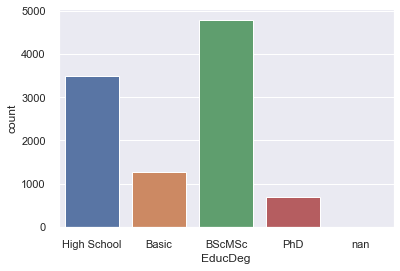

In [36]:
# Counting the genders in the dataset.

sns.countplot(data=ds, x="EducDeg")
plt.show()

We need to get rid of the nans.

In [37]:
ds = ds[~ds['EducDeg'].isin([np.nan, 'nan'])]

In [38]:
ds['EducDeg'].unique()

array(['High School', 'Basic', 'BScMSc', 'PhD'], dtype=object)

In [39]:
ds.shape

(10248, 13)

### **The variable 'MonthSal':**

In [40]:
ds['MonthSal'].unique()

array([2177.,  677., 2277., ..., 3694., 1035., 3975.])

In [41]:
ds['MonthSal'].value_counts()

1398.0    10
3560.0    10
2687.0    10
3776.0    10
2073.0     9
          ..
1740.0     1
574.0      1
715.0      1
1198.0     1
3975.0     1
Name: MonthSal, Length: 3564, dtype: int64

In [42]:
ds = ds[~ds['MonthSal'].isin([np.nan, 'nan'])]

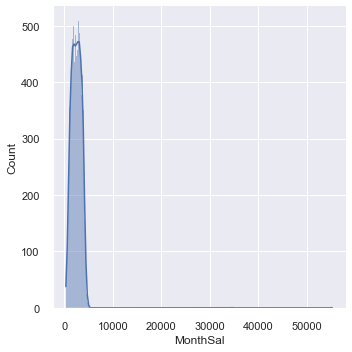

In [43]:
# Checking the histogram of the variable 'MonthSal'

sns.displot(data=ds, x="MonthSal", kde=True)
plt.show()

The figure above shows the presence of outliers values that are very far from the true distribution of salaries.

In [44]:
ds.shape

(10215, 13)

### **The variable 'GeoLivArea':**

In [45]:
ds['GeoLivArea'].unique()

array([1., 4., 3., 2.])

In [46]:
ds['GeoLivArea'].value_counts()

4.0    4118
1.0    3021
3.0    2055
2.0    1021
Name: GeoLivArea, dtype: int64

We need to remove the nans values.

In [47]:
ds = ds[~ds['GeoLivArea'].isin([np.nan, 'nan'])]

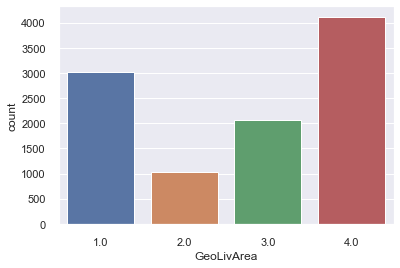

In [48]:
# Counting the 'GeoLivArea' in the dataset.

sns.countplot(data=ds, x="GeoLivArea")
plt.show()

In [49]:
ds.shape

(10215, 13)

### **The variable 'Children':**

In [50]:
ds['Children'].unique()

array([ 1.,  0., nan])

In [51]:
ds['Children'].value_counts()

1.0    7211
0.0    2991
Name: Children, dtype: int64

Again we need to get rid of the nans.

In [52]:
ds = ds[~ds['Children'].isin([np.nan, 'nan'])]

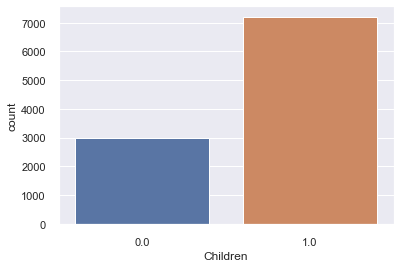

In [53]:
# Counting the 'Children' in the dataset.

sns.countplot(data=ds, x="Children")
plt.show()

We can see that most people in the dataset have children.

In [54]:
ds['Children'].unique()

array([1., 0.])

In [55]:
ds.shape

(10202, 13)

### The variable 'CustMonVal':

In [56]:
ds['CustMonVal'].unique()

array([ 380.97, -131.13,  504.67, ..., 1405.6 ,  524.1 ,  463.75])

In [57]:
ds['CustMonVal'].value_counts()

-25.00     267
-31.00      12
-35.00      11
-37.00      10
-15.11      10
          ... 
 376.19      1
 50.45       1
-8.11        1
 478.20      1
 463.75      1
Name: CustMonVal, Length: 6972, dtype: int64

In [58]:
ds = ds[~ds['CustMonVal'].isin([np.nan, 'nan'])]

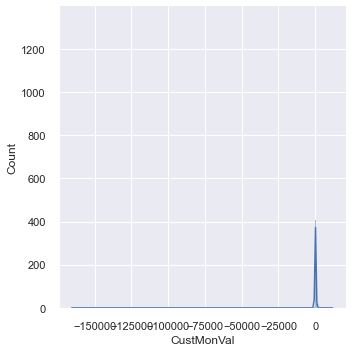

In [59]:
# Checking the histogram of the variable 'MonthSal'

sns.displot(data=ds, x="CustMonVal", kde=True)
plt.show()

We can see observations with very small negative values, they might be outliers we will decide how to deal with them in the next steps.

In [60]:
ds.shape

(10202, 13)

### **The variable 'ClaimsRate':**

In [61]:
ds['ClaimsRate'].unique()

array([  0.39,   1.12,   0.28,   0.99,   0.9 ,   1.  ,   1.05,   1.13,
         0.36,   0.53,   0.46,   0.97,   1.06,   0.89,   0.85,   0.71,
         1.08,   0.64,   0.81,   0.41,   0.38,   0.5 ,   0.96,   0.19,
         0.69,   0.48,   0.94,   1.01,   0.98,   0.84,   0.47,   1.07,
         1.19,   0.63,   1.2 ,   0.32,  25.36,   1.14,   0.59,   0.13,
         0.66,   0.68,   0.61,   0.78,   0.33,   0.72,   0.2 ,   1.04,
         0.42,   0.95,   0.35,   1.03,   1.21,   0.4 ,   0.44,   0.77,
         0.93,   0.54,   0.25,   0.43,  15.65,   0.49,   0.14,   0.62,
         0.56,   0.57,   0.18,   0.91,   0.82,   0.12,  14.8 ,   0.65,
         0.31,   0.09,   0.22,   0.06,   0.3 ,   0.51,   0.26,   0.52,
         0.67,   0.58, 256.2 ,   0.29,   0.86,   0.6 ,   0.27,   0.79,
         0.88,   0.21,   0.24,   0.45,   0.23,   0.  ,   0.16,   0.07,
         0.75,   0.55,   0.08,   0.11,   0.37,   1.02,   1.3 ,   0.7 ,
         0.87,   1.1 ,   1.16,   0.92,   0.05,   0.83,   1.09,   1.25,
      

This variable does not contains any nans.
We will plot its histogram.

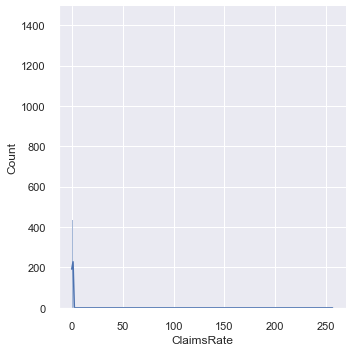

In [62]:
# Checking the histogram of the variable 'ClaimsRate'

sns.displot(data=ds, x="ClaimsRate", kde=True)
plt.show()

We can see that the variable contains some outliers with claims Rate above 250.

In [63]:
ds.shape

(10202, 13)

### **The variable 'PremMotor':**

In [64]:
ds['PremMotor'].unique()

array([375.85,  77.46, 206.15, ..., 105.13, 556.77,   6.89])

In [65]:
ds['PremMotor'].value_counts()

361.29    16
398.74    16
246.49    16
279.61    15
206.15    15
          ..
546.66     1
402.63     1
564.44     1
507.43     1
6.89       1
Name: PremMotor, Length: 1950, dtype: int64

In [66]:
ds = ds[~ds['PremMotor'].isin([np.nan, 'nan'])]

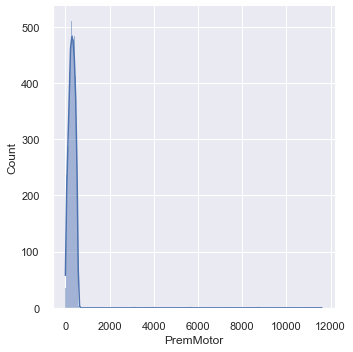

In [67]:
# Checking the histogram of the variable 'PremMotor'

sns.displot(data=ds, x="PremMotor", kde=True)
plt.show()

The variable seems to contains some outliers.

In [68]:
ds.shape

(10171, 13)

### **The variable 'PremHousehold':**

In [69]:
ds['PremHousehold'].unique()

array([  79.45,  416.2 ,  224.5 , ..., 1070.2 , 1045.75, 1035.75])

In [70]:
ds['PremHousehold'].value_counts()

 39.45      62
-45.55      60
 19.45      60
-30.55      57
-5.55       56
            ..
 1110.20     1
 392.30      1
 977.95      1
 1826.45     1
 1035.75     1
Name: PremHousehold, Length: 1061, dtype: int64

In [71]:
ds = ds[~ds['PremHousehold'].isin([np.nan, 'nan'])]

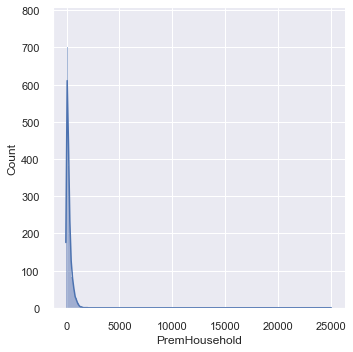

In [72]:
# Checking the histogram of the variable 'PremHousehold'

sns.displot(data=ds, x="PremHousehold", kde=True)
plt.show()

The distribution is right skewed as it contains very big Household premiums values.

In [73]:
ds.shape

(10171, 13)

### **The variable 'Premhealth':**

In [74]:
ds['PremHealth'].unique()

array([146.36, 116.69, 124.58, ..., 327.73, 390.74, 417.08])

In [75]:
ds['PremHealth'].value_counts()

130.47    30
178.70    29
159.14    27
169.70    26
147.36    26
          ..
316.95     1
374.96     1
298.28     1
354.29     1
417.08     1
Name: PremHealth, Length: 1006, dtype: int64

In [76]:
ds = ds[~ds['PremHealth'].isin([np.nan, 'nan'])]

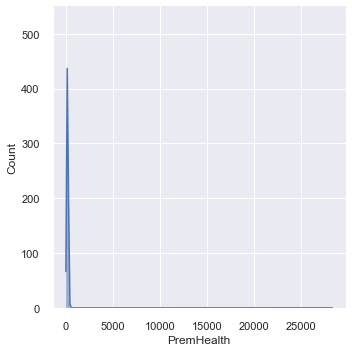

In [77]:
# Checking the histogram of the variable 'PremHealth'

sns.displot(data=ds, x="PremHealth", kde=True)
plt.show()

Right skewed distribution with very high values.

In [78]:
ds.shape

(10144, 13)

### **The variable 'PremLife':**

In [79]:
ds['PremLife'].isna().sum()

89

In [80]:
ds['PremLife'].unique()

array([ 47.01, 194.48,  86.35,  35.34,  18.78,   7.  ,  14.67,  66.68,
         8.78,  39.23,  18.67,  36.34,  43.12, 267.94,  10.89,  -3.  ,
       125.58,   3.89,  14.78,  24.45,  64.79,  48.01,  15.67,  17.56,
        -5.  ,  17.78,  -4.  ,  46.12,   4.78,  22.56,  40.23, 111.8 ,
        26.56,   3.  ,  53.01,  17.67, 146.36, 108.02,  52.01, 224.71,
       106.13,  59.79,  72.68,   1.89,  16.78,   5.  ,  12.78,  44.12,
        12.89,  -1.11,   6.  ,  69.68,  52.9 ,  30.34,  23.45,   6.89,
        16.56,  32.34,    nan,  20.56,  65.68,  70.79,  56.9 ,  51.12,
        22.67,  51.9 ,  48.12,  39.34,  29.56,   0.89,  30.56,   7.89,
        -6.  ,  38.23,  31.34,  32.45,  11.67,  31.45,  60.79,  -1.  ,
       185.48,  23.67,  67.68,  37.23,  19.56,  13.78,  12.67, 213.04,
         1.  ,  35.23,  29.34,   9.78,   2.89,   8.89,  29.45,  87.24,
        93.35,  11.89,   9.89,  71.79,  98.24,  37.34,  10.78,  21.56,
       136.47,  41.12, 104.02,  30.45,  73.57,  47.23, 131.47,  18.56,
      

In [81]:
ds['PremLife'].value_counts()

 9.89      129
 3.89      118
 0.89      118
-1.11      113
 6.89      106
          ... 
 204.26      1
 245.38      1
 170.70      1
 189.59      1
 270.83      1
Name: PremLife, Length: 611, dtype: int64

In [82]:
ds = ds[~ds['PremLife'].isin([np.nan, 'nan'])]

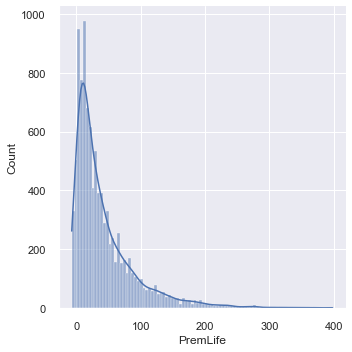

In [83]:
# Checking the histogram of the variable 'PremLife'

sns.displot(data=ds, x="PremLife", kde=True)
plt.show()

Right skewed distribution, but does not seem to contain outliers.

In [84]:
ds['PremLife'].unique()

array([ 47.01, 194.48,  86.35,  35.34,  18.78,   7.  ,  14.67,  66.68,
         8.78,  39.23,  18.67,  36.34,  43.12, 267.94,  10.89,  -3.  ,
       125.58,   3.89,  14.78,  24.45,  64.79,  48.01,  15.67,  17.56,
        -5.  ,  17.78,  -4.  ,  46.12,   4.78,  22.56,  40.23, 111.8 ,
        26.56,   3.  ,  53.01,  17.67, 146.36, 108.02,  52.01, 224.71,
       106.13,  59.79,  72.68,   1.89,  16.78,   5.  ,  12.78,  44.12,
        12.89,  -1.11,   6.  ,  69.68,  52.9 ,  30.34,  23.45,   6.89,
        16.56,  32.34,  20.56,  65.68,  70.79,  56.9 ,  51.12,  22.67,
        51.9 ,  48.12,  39.34,  29.56,   0.89,  30.56,   7.89,  -6.  ,
        38.23,  31.34,  32.45,  11.67,  31.45,  60.79,  -1.  , 185.48,
        23.67,  67.68,  37.23,  19.56,  13.78,  12.67, 213.04,   1.  ,
        35.23,  29.34,   9.78,   2.89,   8.89,  29.45,  87.24,  93.35,
        11.89,   9.89,  71.79,  98.24,  37.34,  10.78,  21.56, 136.47,
        41.12, 104.02,  30.45,  73.57,  47.23, 131.47,  18.56,  -0.11,
      

In [85]:
ds.shape

(10055, 13)

### **The variable 'PremWork':**

In [86]:
ds['PremWork'].unique()

array([  16.89,  106.13,   99.02,   28.34,   41.45,    7.67,   26.34,
         53.23,    9.89,   55.12,   10.89,   35.45,   15.78,   94.46,
         19.67,   37.23,   27.56,   72.57,   30.56,   33.34,   54.9 ,
         33.56,    4.78,   22.78,    9.78,   -0.11,   -5.  ,   -5.11,
          9.67,    7.89,   72.68,   65.79,   84.35,   40.23,    5.78,
        148.03,   25.34,   25.56,   23.34,   44.23,   75.79,   69.9 ,
         14.89,    3.89,   -9.  ,   30.45,    2.78,   10.  ,   62.68,
         16.78,   51.12,    8.78,   48.12,   -4.11,   -6.11,   97.35,
         17.89,   79.68,   33.23,   59.9 ,   20.78,    0.89,   29.67,
         73.68,   50.01,   -3.11,   30.23,   21.67,   17.78,    5.67,
         64.01,    8.67,   -1.  ,   12.67,   19.45,   29.56,   41.12,
         20.56,   -8.  ,  118.91,   59.68,   37.34,    6.89,  156.03,
        118.58,   28.45,   40.34,   14.67,  146.14,   16.56,   -1.11,
         99.35,  -12.  ,   60.9 ,   70.46,   26.56,   64.57,   41.23,
         68.68,   36

In [87]:
ds = ds[~ds['PremWork'].isin([np.nan, 'nan'])]

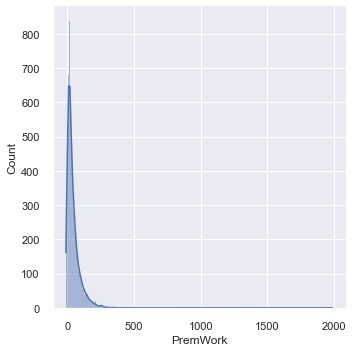

In [88]:
# Checking the histogram of the variable 'PremWork'

sns.displot(data=ds, x="PremWork", kde=True)
plt.show()

Right skewed distribution.

In [89]:
ds['PremWork'].unique()

array([  16.89,  106.13,   99.02,   28.34,   41.45,    7.67,   26.34,
         53.23,    9.89,   55.12,   10.89,   35.45,   15.78,   94.46,
         19.67,   37.23,   27.56,   72.57,   30.56,   33.34,   54.9 ,
         33.56,    4.78,   22.78,    9.78,   -0.11,   -5.  ,   -5.11,
          9.67,    7.89,   72.68,   65.79,   84.35,   40.23,    5.78,
        148.03,   25.34,   25.56,   23.34,   44.23,   75.79,   69.9 ,
         14.89,    3.89,   -9.  ,   30.45,    2.78,   10.  ,   62.68,
         16.78,   51.12,    8.78,   48.12,   -4.11,   -6.11,   97.35,
         17.89,   79.68,   33.23,   59.9 ,   20.78,    0.89,   29.67,
         73.68,   50.01,   -3.11,   30.23,   21.67,   17.78,    5.67,
         64.01,    8.67,   -1.  ,   12.67,   19.45,   29.56,   41.12,
         20.56,   -8.  ,  118.91,   59.68,   37.34,    6.89,  156.03,
        118.58,   28.45,   40.34,   14.67,  146.14,   16.56,   -1.11,
         99.35,  -12.  ,   60.9 ,   70.46,   26.56,   64.57,   41.23,
         68.68,   36

In [90]:
ds.shape

(9985, 13)

### Checking for missing values:

In [91]:
ds.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

We now have no missing data left.

In [92]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

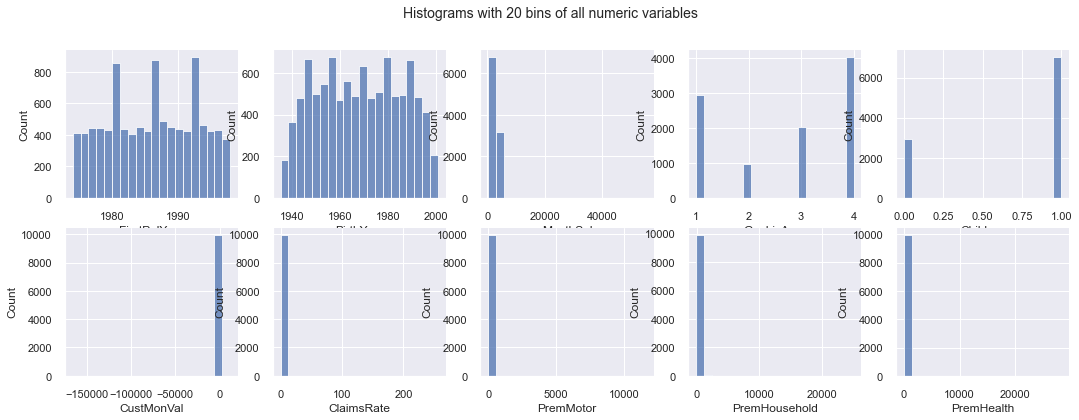

In [93]:
# HISTOGRAM (ALL NUMERIC VARIABLES)

# Identify all numeric variables in the dataset
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()

# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.histplot(data=ds,
                bins=20,
                 x=var,
                 ax=subplot,
                 kde=False)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=plots_Title_fontSize);

___

# **2. Features Engineering:**

### __Converting 'BirthYear' into 'Age':__

We convert the variable 'BirthYear' into 'Age'.

In [94]:
ds['Age'] = 2016 - ds['BirthYear']

In [95]:
ds.drop(columns=['BirthYear'], inplace=True)

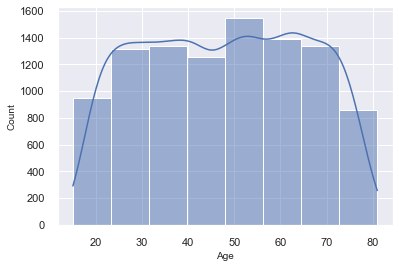

In [96]:
# Checking the histogram of the variable 'Age'.

sns.histplot(data=ds, x="Age", bins=8, kde=True)
plt.show()

### __Converting the variable 'FirstPolYear' into 'YearsAsCustomer':__

We convert the variable 'FirstPolYear' into 'YearsAsCustumer'

In [97]:
ds['YearsAsCustomer'] = 2016 - ds['FirstPolYear']

In [98]:
ds.drop(columns=['FirstPolYear'], inplace=True)

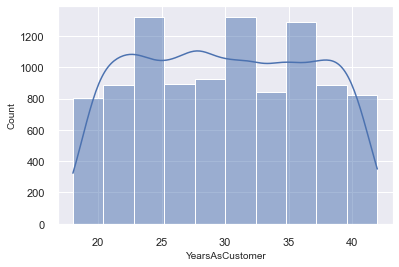

In [99]:
# Checking the histogram of the variable 'YearsAsCustumer'.

sns.histplot(data=ds, x="YearsAsCustomer", bins=10, kde=True)
plt.show()

In [100]:
ds.shape

(9985, 13)

___

# **3. Data Prepararion:**

In [101]:
X = ds.copy(deep=True)

In [102]:
X.shape

(9985, 13)

## __Hopkins Statistic to data set:__

In [103]:
#hopkins(X, len(X))

- Hopkins test is a statistical test for spatial randomness of a variable, it can be used to measure the probability of data points generated by uniform data distribution. Non-uniform distribution of points in data set are important in clustering, they confirm that the data does contain clustering tendency.

## __Encoding categorical variables:__

In [104]:
# Encode categorical variables to dummy variables
# For more information the different methods to enconde categorical variables
# check https://contrib.scikit-learn.org/category_encoders/
cat_vars = ['EducDeg', 'GeoLivArea', 'Children']
ce_one_hot = ce.OneHotEncoder(cols = cat_vars, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

## __Removing numerical outliers:__

In [105]:
X.shape

(9985, 20)

In [106]:
num_vars = ["MonthSal", "CustMonVal", "ClaimsRate", "PremMotor", "PremHousehold", "PremHealth", 
            "PremLife", "PremWork"]

In [107]:
X[num_vars].describe().T

count         mean          std        min      25%      50%  \
MonthSal       9985.0  2505.675113  1164.237744     333.00  1700.00  2500.00   
CustMonVal     9985.0   177.798403  1975.430380 -165680.42    -8.22   187.82   
ClaimsRate     9985.0     0.745466     2.961024       0.00     0.40     0.72   
PremMotor      9985.0   298.926115   213.385202      -4.11   189.59   297.28   
PremHousehold  9985.0   213.013130   356.143193     -75.00    50.00   133.90   
PremHealth     9985.0   172.314024   300.084756      -2.11   112.02   163.03   
PremLife       9985.0    42.013345    47.627004      -7.00     9.89    25.56   
PremWork       9985.0    41.505458    51.737804     -12.00    10.67    26.34   

                   75%       max  
MonthSal       3293.00  55215.00  
CustMonVal      399.86  11875.89  
ClaimsRate        0.98    256.20  
PremMotor       406.30  11604.42  
PremHousehold   294.50  25048.80  
PremHealth      219.93  28272.00  
PremLife         57.90    398.30  
PremWork         56.79   1988.70

In [108]:
X_out, X_outliers = removeOutliers(X, num_vars, lowPercentile=0.05, highPercentile=0.95, verbose=True)

      MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0.05     929.4     -93.790        0.16     62.922          -30.0        54.9   
0.95    4046.0     648.424        1.10    513.540          696.8       297.5   

      PremLife  PremWork  
0.05     -1.11    -3.822  
0.95    140.47   137.580  


In [109]:
print(X_out.shape)
print(X_outliers.shape)

(5863, 20)
(365, 20)


In [110]:
X_out[num_vars].describe().T

count         mean         std     min       25%      50%  \
MonthSal       5863.0  2576.586219  829.936902  931.00  1860.500  2594.00   
CustMonVal     5863.0   202.987784  198.943351  -93.79     6.795   192.60   
ClaimsRate     5863.0     0.685647    0.276897    0.16     0.430     0.72   
PremMotor      5863.0   315.917118  101.075412   63.68   241.380   319.17   
PremHousehold  5863.0   169.715018  147.803669  -30.00    59.450   131.70   
PremHealth     5863.0   172.150769   59.684333   54.90   124.690   168.92   
PremLife       5863.0    34.003925   29.443670   -1.11    11.780    24.67   
PremWork       5863.0    33.889444   29.204508   -3.11    12.000    25.34   

                   75%      max  
MonthSal       3284.50  4046.00  
CustMonVal      376.91   646.80  
ClaimsRate        0.95     1.10  
PremMotor       396.63   513.54  
PremHousehold   245.05   696.80  
PremHealth      218.04   297.50  
PremLife         48.12   140.25  
PremWork         48.23   137.47

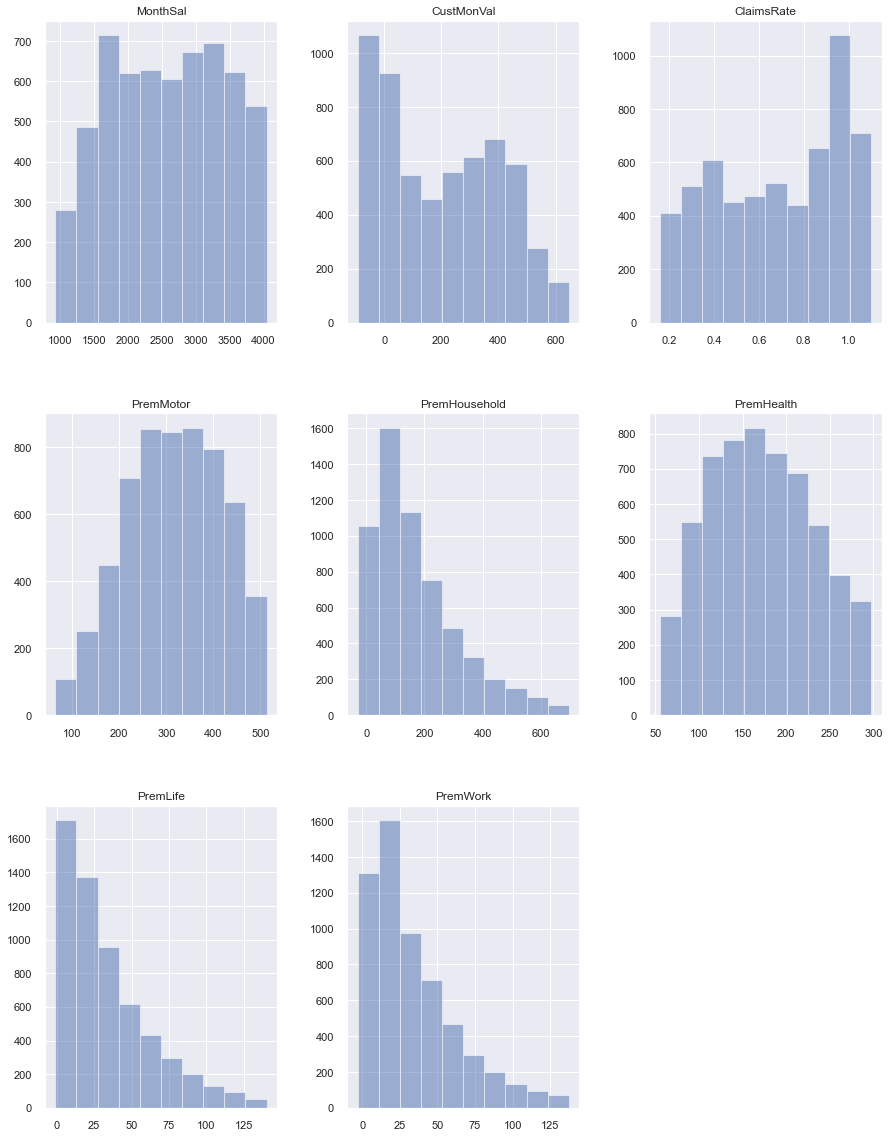

In [111]:
X_out[num_vars].hist(color='b', alpha=0.5, bins=10, figsize = (15,20))
plt.show()

In [112]:
X_out["CustMonVal"].min()

-93.79

In [113]:
X = X_out.copy(deep=True)

## __Scaling the numerical variables:__

Get a copy of the dataframe before normalization for results' analysis

In [114]:
X_beforeNorm = X.copy(deep=True)

In [115]:
num_vars += ['Age', 'YearsAsCustomer'] 

In [116]:
# Normalize all columns
# MinMax scaler returns an array, so the dataframe must be recreated
X[num_vars] = pd.DataFrame(StandardScaler().fit_transform(X[num_vars].values), 
                           columns=num_vars,index=X.index)
# MinMaxScaler()

In [117]:
# Check dataframe structure and statistics after all transformations
print(X.shape)
X[num_vars].describe().T

(5863, 20)


count          mean       std       min       25%       50%  \
MonthSal         5863.0 -1.040728e-16  1.000085 -1.982954 -0.862894  0.020984   
CustMonVal       5863.0 -1.261901e-16  1.000085 -1.491898 -0.986258 -0.052219   
ClaimsRate       5863.0  2.741946e-16  1.000085 -1.898511 -0.923336  0.124074   
PremMotor        5863.0 -1.555411e-16  1.000085 -2.495747 -0.737504  0.032185   
PremHousehold    5863.0 -2.264378e-16  1.000085 -1.351334 -0.746087 -0.257221   
PremHealth       5863.0  2.602955e-16  1.000085 -1.964683 -0.795264 -0.054136   
PremLife         5863.0  1.009294e-16  1.000085 -1.192681 -0.754859 -0.317037   
PremWork         5863.0 -9.564620e-17  1.000085 -1.267017 -0.749587 -0.292769   
Age              5863.0  1.083712e-16  1.000085 -2.094193 -0.871567  0.029315   
YearsAsCustomer  5863.0 -2.289373e-16  1.000085 -1.816269 -0.904766  0.006737   

                      75%       max  
MonthSal         0.853046  1.770664  
CustMonVal       0.874304  2.231037  
ClaimsRate       0.954778  1.496542  
PremMotor        0.798609  1.955369  
PremHousehold    0.509740  3.566420  
PremHealth       0.768931  2.100382  
PremLife         0.479467  3.608760  
PremWork         0.491081  3.547034  
Age              0.865849  2.024126  
YearsAsCustomer  0.918240  1.829743

- The results transformation made the modeling dataset end up with 20 columns.
- All columns are now numeric, with values in the range of 0 to 1

___

# **4. Analyze Principal Components:**

Visualizing the PCA with only two components.

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000028331628AF0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000028331628AF0> on colorbar
Setting pcolormesh


(5863, 2)


top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


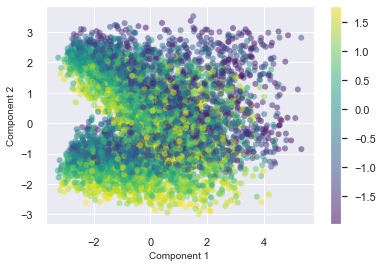

In [118]:
pca2 = PCA(n_components = 2, random_state=random_state)
pca2.fit(X[num_vars])
X_pca2 = pca2.transform(X[num_vars])
print(X_pca2.shape)

# Scatter plot of the two Principal Components by the "target" to see if there is any pattern
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=X["MonthSal"], edgecolor='none', alpha=0.5, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show();

- The plot above does not show any clusters.

In [119]:
# Fit the PCA algorithm to the dataset. 
pca = PCA().fit(X)

# Output PCA table
pcaDF=pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": 100*np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

pcaDF

Eigenvalue    Difference    Proportion  Cumulative
1   2.871917e+00  0.000000e+00  2.453993e-01   24.539928
2   2.069162e+00 -8.027555e-01  1.768055e-01   42.220479
3   1.956134e+00 -1.130281e-01  1.671475e-01   58.935229
4   9.993593e-01 -9.567745e-01  8.539314e-02   67.474543
5   9.612345e-01 -3.812480e-02  8.213546e-02   75.688089
6   6.299329e-01 -3.313016e-01  5.382644e-02   81.070733
7   6.074783e-01 -2.245458e-02  5.190774e-02   86.261507
8   3.777556e-01 -2.297227e-01  3.227842e-02   89.489348
9   3.474954e-01 -3.026023e-02  2.969275e-02   92.458623
10  2.350305e-01 -1.124649e-01  2.008286e-02   94.466909
11  2.305722e-01 -4.458298e-03  1.970190e-02   96.437099
12  1.231054e-01 -1.074668e-01  1.051909e-02   97.489008
13  1.145432e-01 -8.562193e-03  9.787472e-03   98.467756
14  8.918615e-02 -2.535703e-02  7.620768e-03   99.229832
15  6.461698e-02 -2.456916e-02  5.521385e-03   99.781971
16  1.497124e-02 -4.964575e-02  1.279261e-03   99.909897
17  1.054479e-02 -4.426451e-03  9.010298e-04  100.000000
18  8.776966e-31 -1.054479e-02  7.499732e-32  100.000000
19  1.885371e-32 -8.588429e-31  1.611010e-33  100.000000
20  2.113177e-36 -1.885160e-32  1.805665e-37  100.000000

- From the above we can see that two components only explain 40.57% of the variance, meaning its not enough to select the number of clusters using the plot above.

No handles with labels found to put in legend.


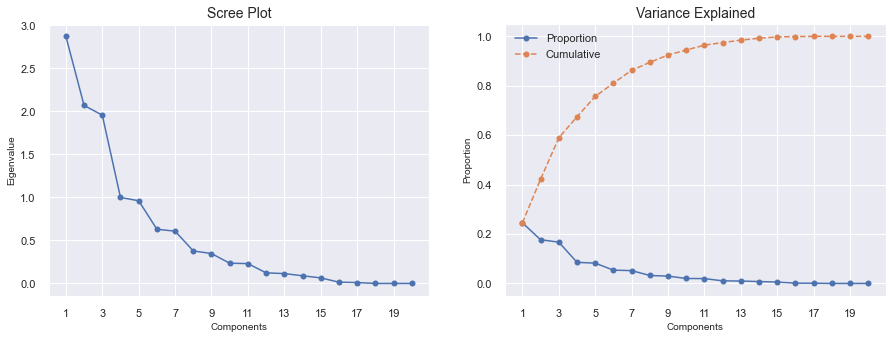

In [120]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax1.legend()
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [121]:
np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9)

8

- checking the number of components that have an acumulated variance bigger that 90%.

___

# **5. KMeans:**

### *Characteristics:*
- *Number of clusters* need to be set apriori.
- One of the *fastest* clustering algorithms.
- The results *depend on the initialization* (stochastic).
- Prone to *local optima*.
- Favors *convex* (round shape) and *isotropic* (same shape) clusters.

## __Defining the number of clusters.__

In [122]:
range_clusters = range(1, 11)

In [123]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=random_state)
    kmclust.fit(X[num_vars])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

**Inertia (within-cluster sum-of-squares distance) Formula:**
$$\sum_{j=0}^{C}\sum_{i=0}^{n_j}(||x_i - \mu_j||^2)$$
, where:

$C$: Set of identified clusters.

$n_j$: Set of observations belonging to cluster $j$.

$x_i$: Observation $i$.

$\mu_j$: Centroid of cluster $j$.

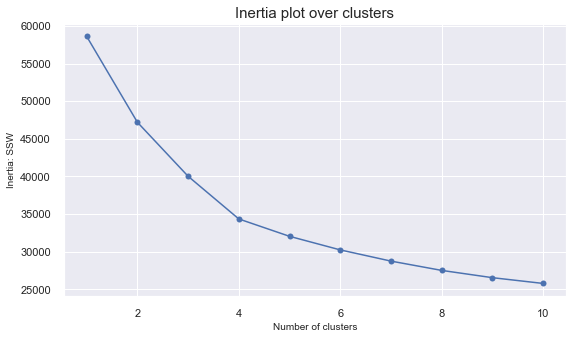

In [124]:
# The inertia plot.
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia, marker=".", markersize=12)
plt.ylabel("Inertia: SSW")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show();

- The plot above shows that the optimal number of clusters is equal to 3.

**Silhouette Coefficient formula for a single sample:**
$$s = \frac{b - a}{max(a, b)}$$
, where:
- $a$: The mean distance between a sample and all other points in the same cluster.
- $b$: The mean distance between a sample and all other points in the next nearest cluster

For n_clusters = 2, the average silhouette_score is : 0.18584189174369112
For n_clusters = 3, the average silhouette_score is : 0.18636671642502736
For n_clusters = 4, the average silhouette_score is : 0.21106136321014168
For n_clusters = 5, the average silhouette_score is : 0.1943143468510442
For n_clusters = 6, the average silhouette_score is : 0.18393406613866461
For n_clusters = 7, the average silhouette_score is : 0.16826899436323986
For n_clusters = 8, the average silhouette_score is : 0.15961009885070152
For n_clusters = 9, the average silhouette_score is : 0.14492840102242324
For n_clusters = 10, the average silhouette_score is : 0.14353411662626475


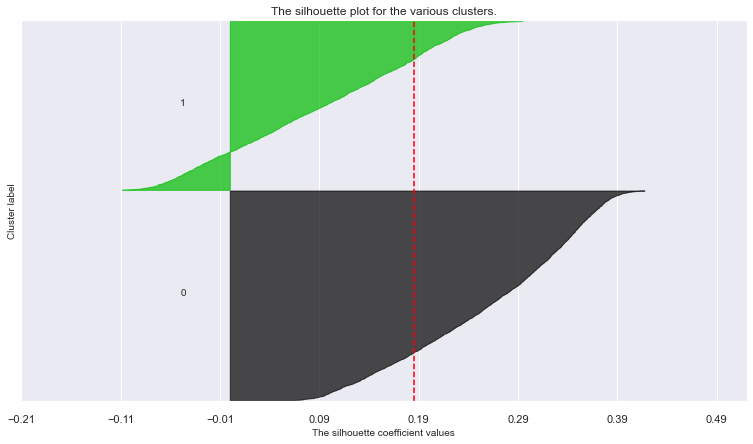

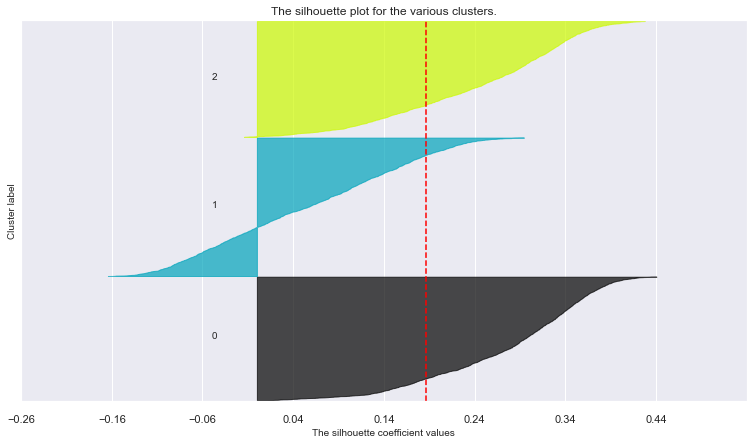

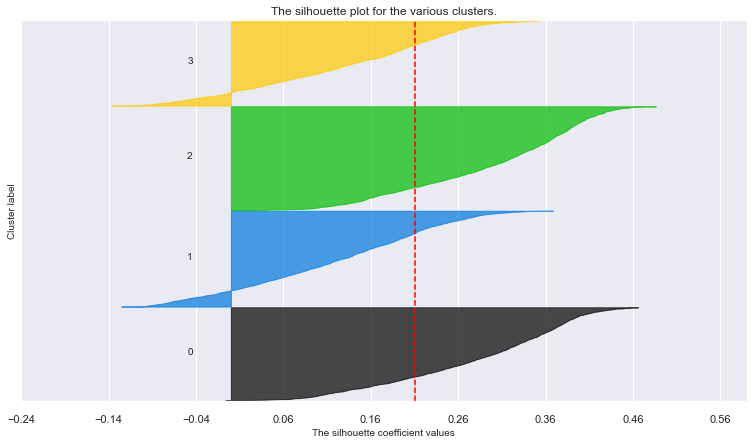

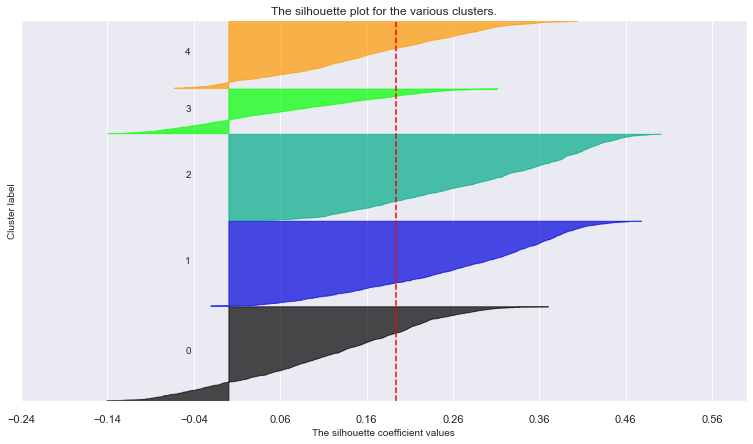

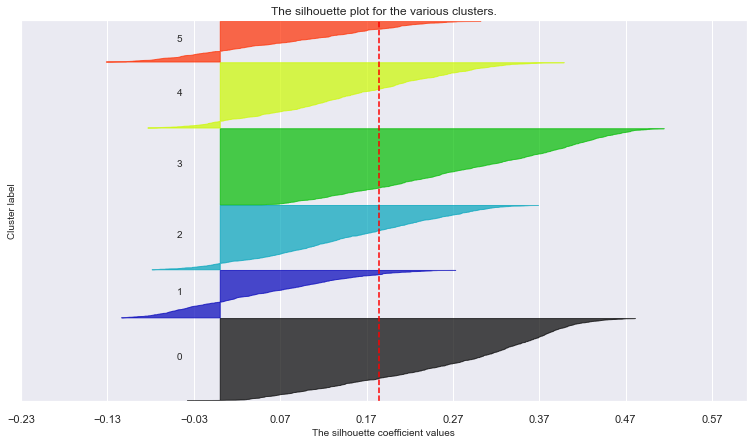

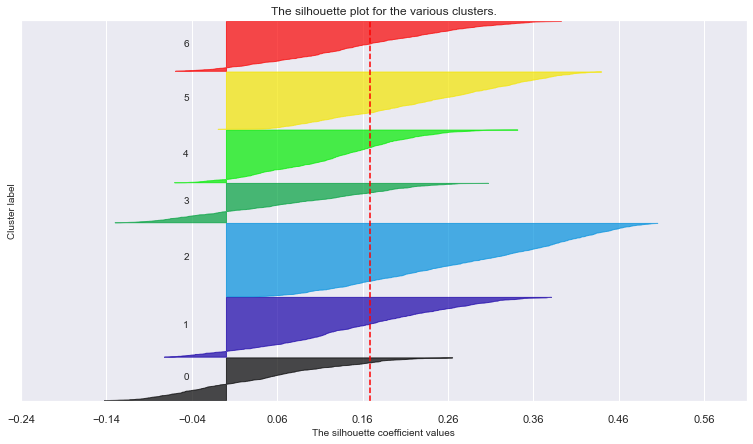

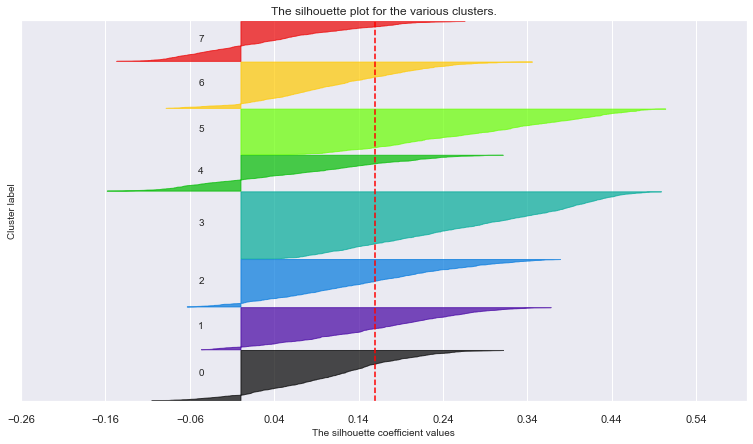

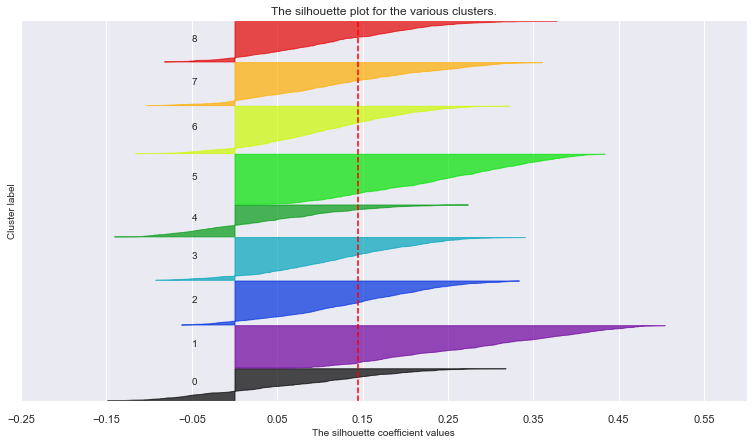

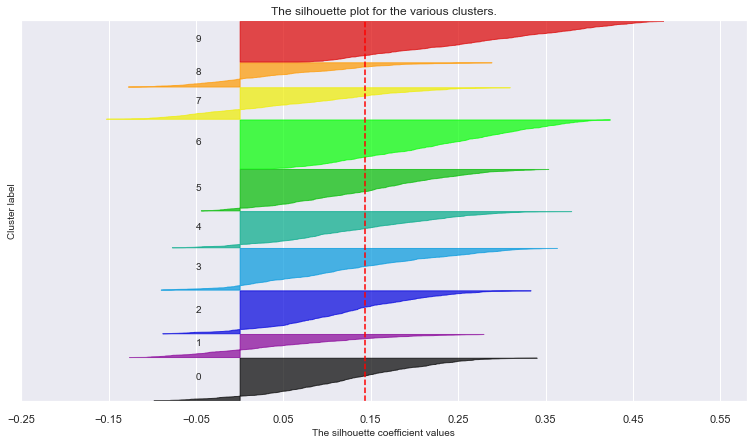

In [125]:
# Calclating the silhouette score.

avg_silhouette = get_avg_silhouette(X[num_vars], KMeans(init='k-means++', n_init=20, random_state=random_state))

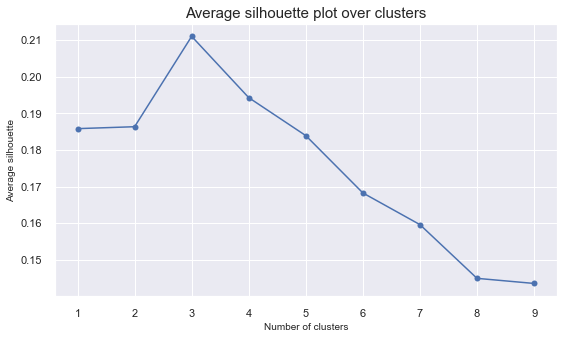

In [126]:
# The average silhouette plot
plt.figure(figsize=(9,5))
plt.plot(range(1,10), avg_silhouette, marker=".", markersize=12)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

- The plot above shows that the optimal number of clusters is equal to 3, which matches the results obtained using the elbow method.

#### **Using Sklearn:**

In [127]:
# final clusters solution:

number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=20, random_state=random_state)
allDistances = kmclust.fit_transform(X[num_vars])
km_labels = kmclust.fit_predict(X[num_vars])

- *init='k-means++'* initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization.  

- *n_init=n* allows to initialize KMeans n times and pick the best clustering in terms of Inertia. 

In [128]:
# Characterizing the final clusters:
X_kmeans = pd.concat((X, pd.Series(km_labels, index=X.index, name='km_labels')), axis=1)

In [129]:
# Characterizing the final clusters:
X_beforeNorm_kmeans = pd.concat((X_beforeNorm, pd.Series(km_labels, index=X_beforeNorm.index,
                                                         name='km_labels')), axis=1)
X_beforeNorm_kmeans.groupby('km_labels').mean().T

km_labels                      0            1            2
EducDeg_High School     0.280793     0.473464     0.271262
EducDeg_Basic           0.048539     0.124767     0.055586
EducDeg_BScMSc          0.574635     0.379423     0.588105
EducDeg_PhD             0.096033     0.022346     0.085047
MonthSal             2653.730167  2480.895251  2608.679822
GeoLivArea_1.0          0.283925     0.290968     0.309616
GeoLivArea_4.0          0.408664     0.413873     0.397443
GeoLivArea_3.0          0.206681     0.195531     0.204558
GeoLivArea_2.0          0.100731     0.099628     0.088382
Children_1.0            0.777662     0.647579     0.782657
Children_0.0            0.222338     0.352421     0.217343
CustMonVal              9.583137   207.709404   403.333124
ClaimsRate              0.950188     0.713655     0.370461
PremMotor             380.572787   211.319642   371.945531
PremHousehold          95.521816   277.932426   119.522235
PremHealth            149.621300   210.614721   150.219639
PremLife               19.784181    56.454264    22.342835
PremWork               20.496576    55.686066    22.128238
Age                    51.054802    47.731844    50.100056
YearsAsCustomer        30.125261    29.699721    30.080600

**Plotting clusters cardinality, magnitude, and cardinality vs magnitude:** 

No handles with labels found to put in legend.


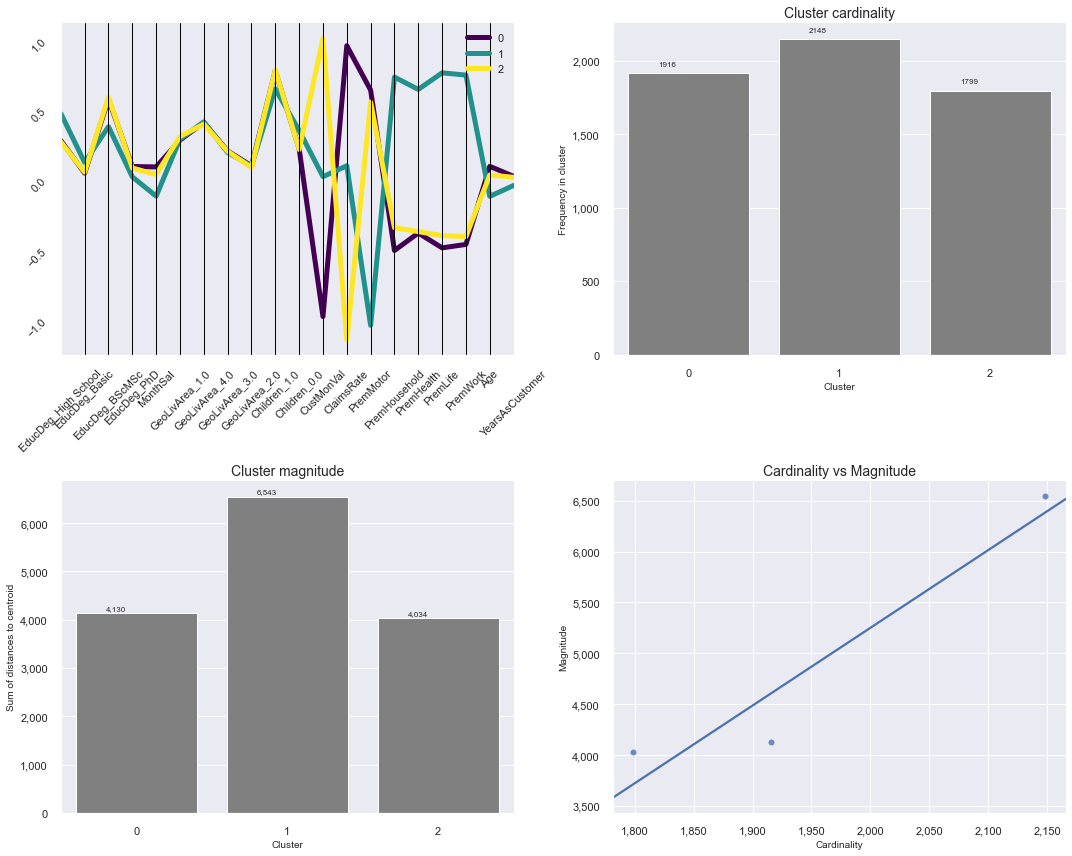

In [130]:
get_cluster_analysis(X_kmeans, "km_labels", allDistances)

**Visualizing the clusters sizes and distances in 2D:**

top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


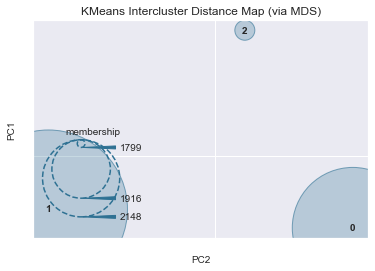

In [131]:
visualizer = InterclusterDistance(kmclust)
visualizer.fit(X[num_vars])
visualizer.show()
plt.show()

#### **Using Scipy:**

In [132]:
# computing K-Means with K clusters.

codebook, distortion = kmeans(X[num_vars], k_or_guess=number_clusters, iter=20)

- **codebook:** A k by N array of k centroids. The ith centroid codebook[i] is represented with the code i. The centroids and codes generated represent the lowest distortion seen, not necessarily the globally minimal distortion. Note that the number of centroids is not necessarily the same as the k_or_guess parameter, because centroids assigned to no observations are removed during iterations.

- **distortion:** The mean (non-squared) Euclidean distance between the observations passed and the centroids generated. Note the difference to the standard definition of distortion in the context of the k-means algorithm, which is the sum of the squared distances.

In [133]:
# assign each sample to a cluster
code, dist = vq(X[num_vars], codebook)

- **code:** A length M array holding the code book index for each observation.

- **dist:** The distortion (distance) between the observation and its nearest code.

In [134]:
# Characterizing the final clusters:
X_kmeans = pd.concat((X, pd.Series(code, index=X.index, name='km_labels')), axis=1)

In [135]:
# Characterizing the final clusters:
X_beforeNorm_kmeans = pd.concat((X_beforeNorm, pd.Series(code, index=X_beforeNorm.index,
                                                         name='km_labels')), axis=1)
X_beforeNorm_kmeans.groupby('km_labels').mean().T

km_labels                      0            1            2
EducDeg_High School     0.469415     0.278160     0.266900
EducDeg_Basic           0.122340     0.048123     0.054779
EducDeg_BScMSc          0.386082     0.576415     0.590326
EducDeg_PhD             0.022163     0.097303     0.087995
MonthSal             2509.612145  2651.583818  2581.990093
GeoLivArea_1.0          0.293440     0.283977     0.307110
GeoLivArea_4.0          0.412234     0.407721     0.399767
GeoLivArea_3.0          0.195479     0.207827     0.203963
GeoLivArea_2.0          0.098848     0.100476     0.089161
Children_1.0            0.642730     0.779482     0.795455
Children_0.0            0.357270     0.220518     0.204545
CustMonVal            209.500541     9.670735   407.457343
ClaimsRate              0.710084     0.950275     0.361906
PremMotor             214.508879   382.312565   376.070495
PremHousehold         273.117176    95.826705   115.197261
PremHealth            210.423989   148.454881   147.945956
PremLife               55.334512    19.618250    21.813660
PremWork               54.803178    20.042819    21.653188
Age                    48.268174    51.034902    49.579837
YearsAsCustomer        29.687943    30.126917    30.118881

**Clusters R²:**

In [136]:
r2_kmm =  get_r2(X_kmeans, "km_labels")
print("Cluster solution with R² of %0.4f" % r2_kmm);

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_kmeans[num_vars + ['km_labels']], 'km_labels').drop('km_labels').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R² of 0.3129


ClaimsRate         0.697788
PremMotor          0.630269
CustMonVal         0.614232
PremLife           0.329167
PremWork           0.321264
PremHousehold      0.308801
PremHealth         0.257250
Age                0.005564
MonthSal           0.005153
YearsAsCustomer    0.001035
dtype: float64

## __Visualization KMeans clusters using Tsne:__

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000283347608E0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000283347608E0> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


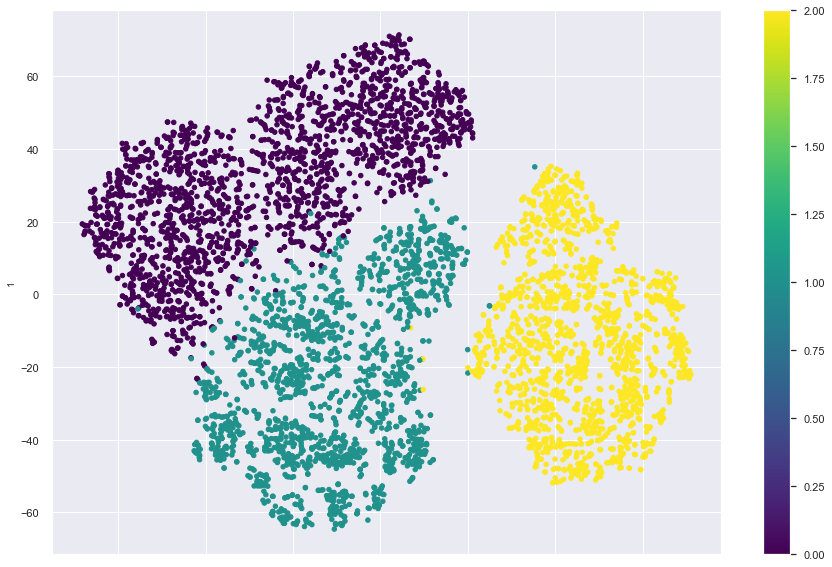

In [137]:
Tsne_km = TSNE(perplexity=30, random_state=random_state).fit_transform(X_kmeans)
pd.DataFrame(Tsne_km).plot.scatter(x=0, y=1, c = X_kmeans['km_labels'],
                                      colormap='viridis', figsize=(15,10))
plt.show();

- INSERT COMMENT HERE.

---

# **6. Hierarchical Clustering:**

### Different types of linkage

![Comparing different hierarchical linkage methods](https://scikit-learn.org/stable/_images/sphx_glr_plot_linkage_comparison_001.png)

**Ward linkage**: minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

### Characteristics:
- *bottom up approach*: each observation starts in its own cluster, and clusters are successively merged together.
- *greedy/local algorithm*: at each iteration tries to minimize the distance of cluster merging.
- *no realocation*: after an observation is assigned to a cluster, it can no longer change.
- *deterministic*: you always get the same answer when you run it.
- *scalability*: can become *very slow* for a large number of observations.

### __Defining the linkage method to choose:__

**We know that:**
$$SS_{t} = SS_{w} + SS_{b}$$

---

$$SS_{t} = \sum\limits_{i = 1}^n {{{({x_i} - \overline x )}^2}}$$

$$SS_{w} = \sum\limits_{k = 1}^K {\sum\limits_{i = 1}^{{n_k}} {{{({x_i} - {{\overline x }_k})}^2}} }$$

$$SS_{b} = \sum\limits_{k = 1}^K {{n_k}{{({{\overline x }_k} - \overline x )}^2}}$$

, where $n$ is the total number of observations, $x_i$ is the vector of the $i^{th}$ observation, $\overline x$ is the centroid of the data, $K$  is the number of clusters, $n_k$ is the number of observations in the $k^{th}$ cluster and $\overline x_k$ is the centroid of the $k^{th}$ cluster.

**Verifying the formula for each variable in the dataframe:**

In [138]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical
    method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt or
    R2 = 1 - SSw/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering.
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods.
    min_nclus (int): minimum number of clusters to compare the methods. Defaults value is 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. 
    Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """    
    def get_ss(df):
        """Computes the sum of squares for all variables given a dataset
        """
        ss = np.sum(df.var()*(df.count() - 1))
        return ss  # return sum of sum of squares of each df variable.
    
    sst = get_ss(df)  # get total sum of squares.
    
    r2 = []  # To store the R2 metrics for each cluster solution.
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) #get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, index = df.index,
                                             name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        r2.append(ssb/sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

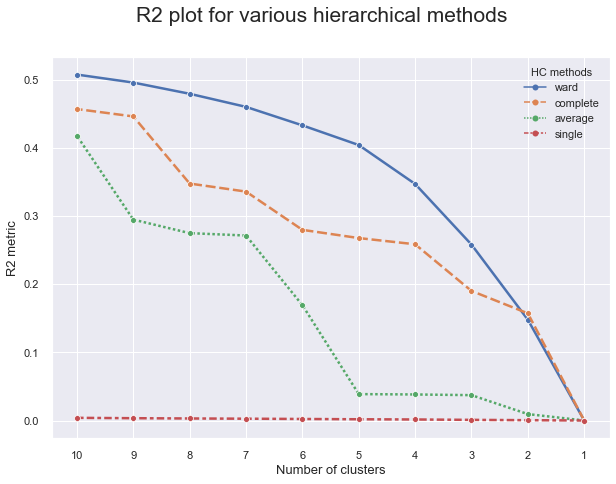

In [139]:
# Preparing the inputs.
hc_methods = ["ward", "complete", "average", "single"]
# Calling the function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=X[num_vars], link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plotting the data:
fig = plt.figure(figsize=(10,7))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis.
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

### __Defining the number of clusters:__
Where is the **first big jump** on the Dendrogram?

Inspired from: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

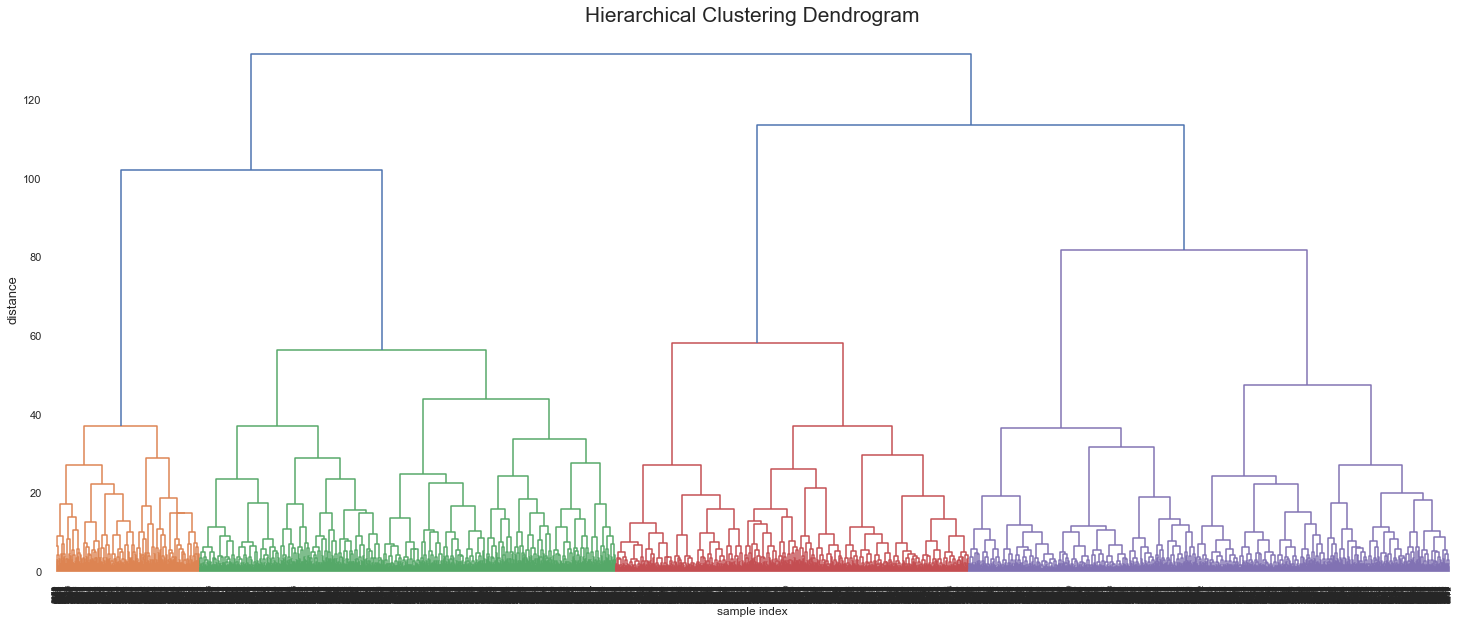

In [140]:
linked = linkage(X[num_vars], method="ward", metric="euclidean")

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('sample index')
plt.ylabel('distance', fontsize=13)
dendrogram(
    linked,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [141]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

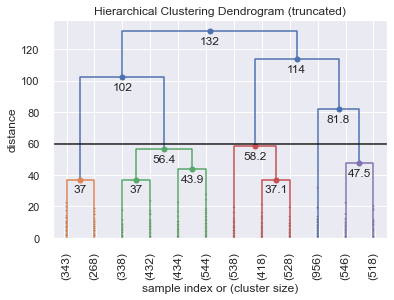

In [142]:
max_d = 60

fancy_dendrogram(
    linked,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.15365453590195802
For n_clusters = 3, the average silhouette_score is : 0.14271637236391307
For n_clusters = 4, the average silhouette_score is : 0.16512812991204834
For n_clusters = 5, the average silhouette_score is : 0.1474786738966744
For n_clusters = 6, the average silhouette_score is : 0.12160890133036083
For n_clusters = 7, the average silhouette_score is : 0.11863541468402355
For n_clusters = 8, the average silhouette_score is : 0.09460031074327417
For n_clusters = 9, the average silhouette_score is : 0.08905659402079366
For n_clusters = 10, the average silhouette_score is : 0.07971031575352949


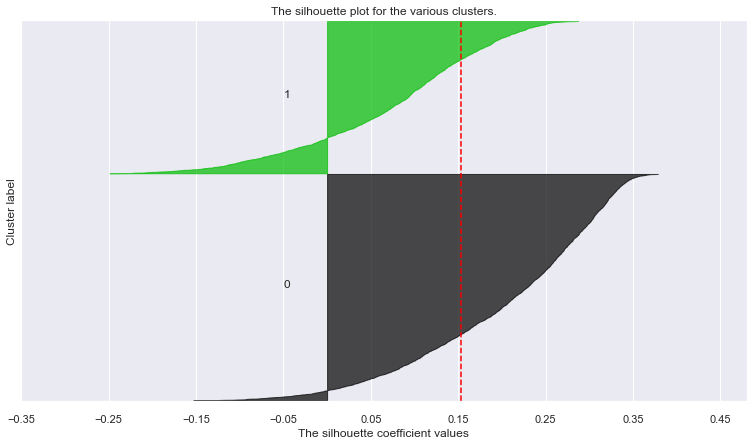

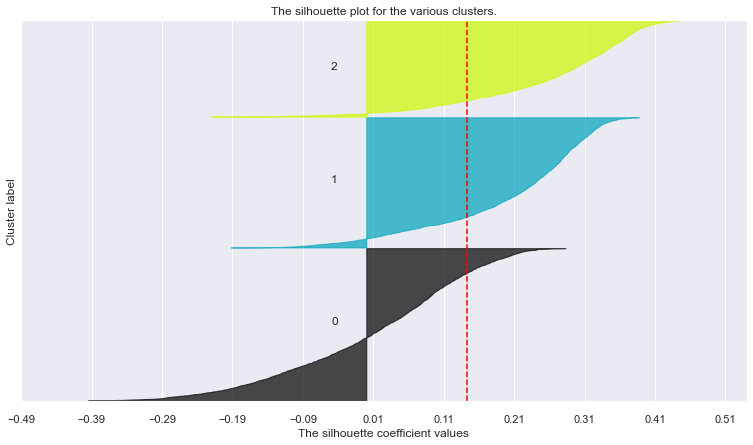

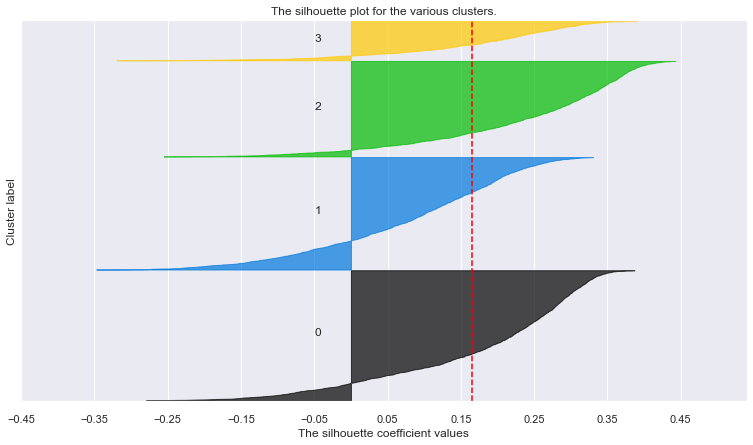

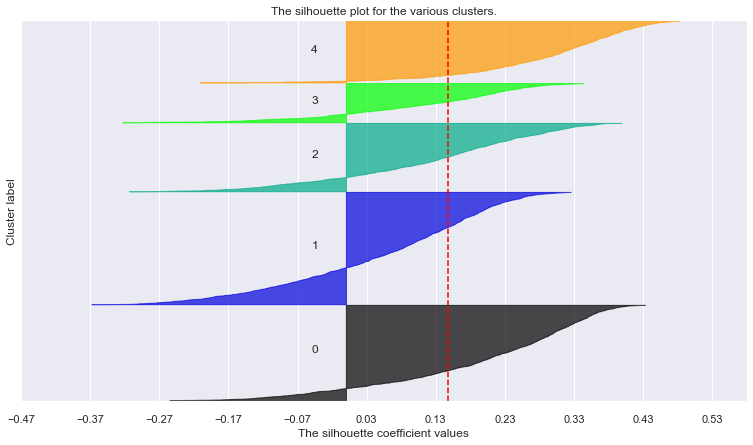

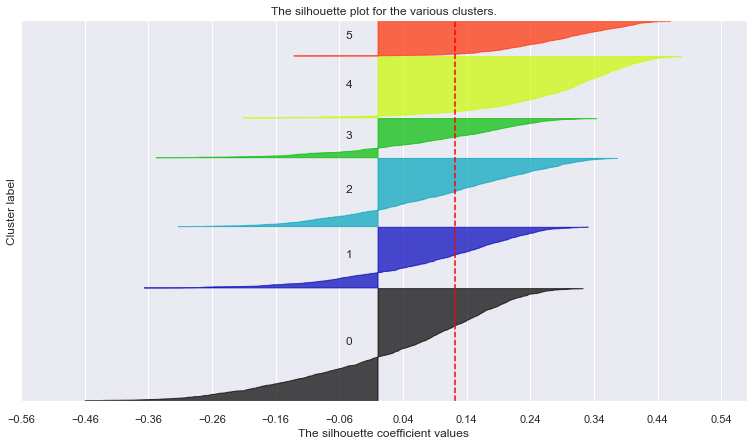

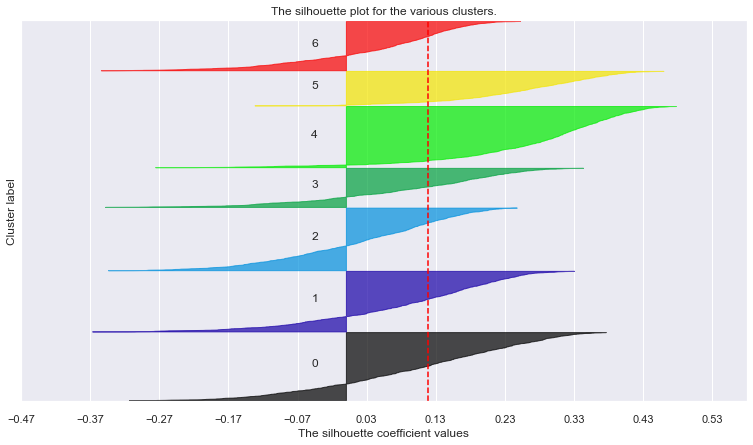

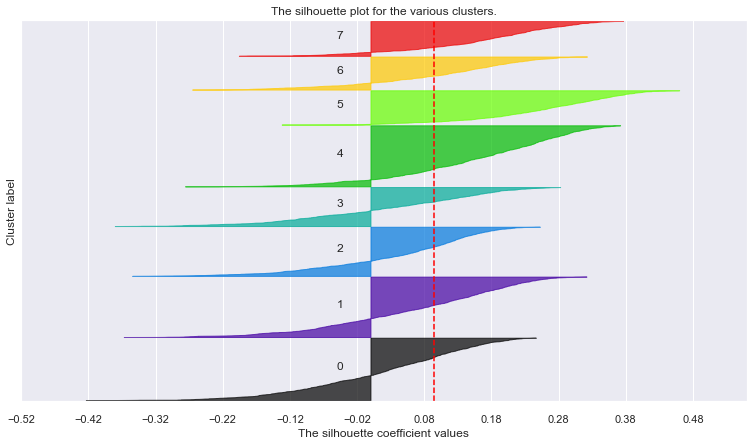

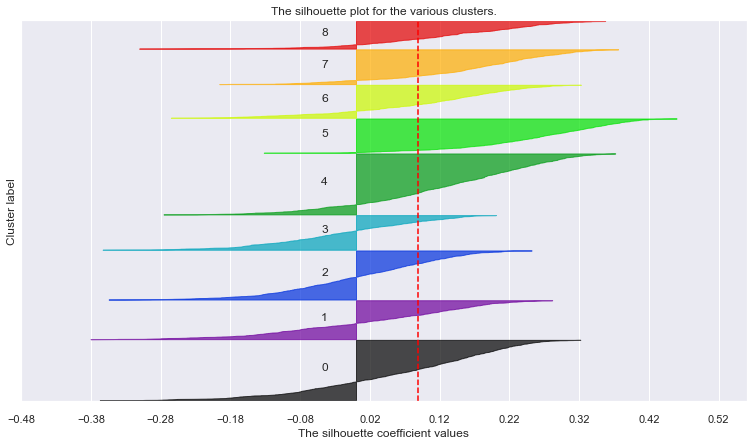

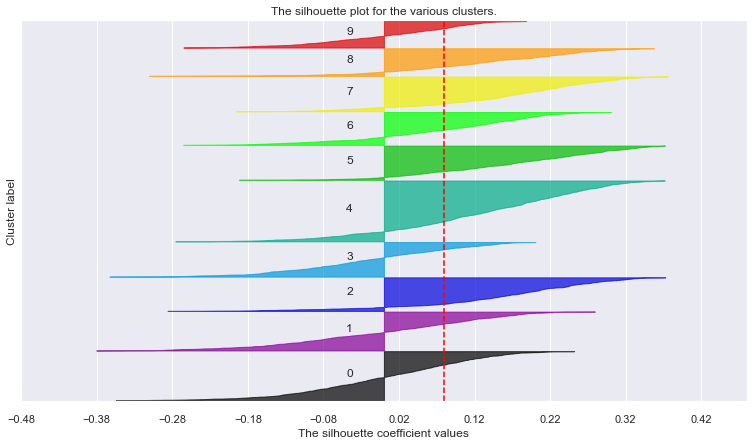

In [143]:
# Getting the silhouette score.

avg_silhouette_hc=get_avg_silhouette(X[num_vars], AgglomerativeClustering(linkage="ward", 
                                                                          affinity="euclidean"))

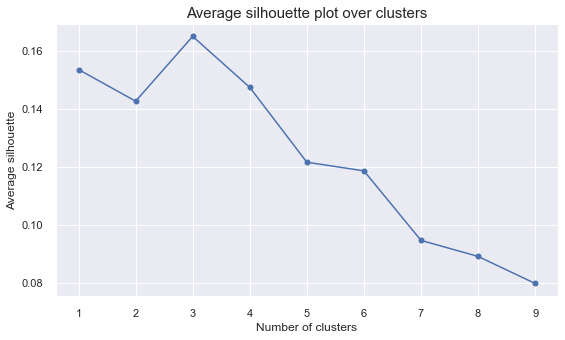

In [144]:
# The average silhouette plot
plt.figure(figsize=(9,5))
plt.plot(range(1,10), avg_silhouette_hc, marker=".", markersize=12)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### __Final Hierarchical clustering solution:__

#### __Using sklearn:__

In [145]:
# 3 cluster solution:
link = 'ward'
distance = 'euclidean'
n_clusters=4
hcclust = AgglomerativeClustering(linkage=link, affinity=distance, 
                                  n_clusters=n_clusters, compute_distances=True)
#allDistances = fit_transform(X[num_vars]) # This function does not exist what should i do.
hc_labels = hcclust.fit_predict(X[num_vars])

In [146]:
# Characterizing the clusters
X_hc = pd.concat((X, pd.Series(hc_labels, index=X.index, name='hc_labels')), axis=1)

**We verify the relation bellow:**
$$SS_{t} = SS_{w} + SS_{b}$$

In [147]:
# Computing SST
X_tmp = X_hc[num_vars+["hc_labels"]].values
sst = np.sum(np.square(X_tmp - X_tmp.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X_tmp[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X_tmp[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X_tmp.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [148]:
# Characterizing the clusters.
X_beforeNorm_hc = pd.concat((X_beforeNorm, pd.Series(hc_labels, index=X_beforeNorm.index, name='hc_labels')), axis=1)
X_beforeNorm_hc.groupby('hc_labels').mean().T

hc_labels                      0            1            2            3
EducDeg_High School     0.303465     0.400458     0.279650     0.515548
EducDeg_Basic           0.058416     0.094394     0.054582     0.158756
EducDeg_BScMSc          0.551980     0.462815     0.576146     0.319149
EducDeg_PhD             0.086139     0.042334     0.089623     0.006547
MonthSal             2365.228713  3349.340389  2330.034367  1663.412439
GeoLivArea_1.0          0.291089     0.283181     0.299865     0.324059
GeoLivArea_4.0          0.404455     0.425057     0.391509     0.402619
GeoLivArea_3.0          0.201485     0.196796     0.216307     0.183306
GeoLivArea_2.0          0.102970     0.094966     0.092318     0.090016
Children_1.0            0.868812     0.415904     0.864555     0.857610
Children_0.0            0.131188     0.584096     0.135445     0.142390
CustMonVal             35.323520   209.838942   405.843982   244.996612
ClaimsRate              0.914782     0.695372     0.362399     0.685401
PremMotor             362.736946   256.126093   379.134879   178.639705
PremHousehold         113.459233   219.261299   116.771395   342.543372
PremHealth            159.635663   199.130675   144.710701   202.986612
PremLife               22.461832    44.966590    21.669899    70.756759
PremWork               22.562381    45.366276    21.819468    67.819083
Age                    45.485644    64.588101    45.003369    30.954173
YearsAsCustomer        30.322772    30.052059    29.710916    29.060556

#### __Using Scipy:__

In [149]:
k=4
hc_labels = fcluster(linked, k, criterion='maxclust')

In [150]:
# Characterizing the clusters
X_hc = pd.concat((X, pd.Series(hc_labels, index=X.index, name='hc_labels')), axis=1)

In [151]:
# Characterizing the clusters.
X_beforeNorm_hc = pd.concat((X_beforeNorm, pd.Series(hc_labels, index=X_beforeNorm.index, name='hc_labels')), axis=1)
X_beforeNorm_hc.groupby('hc_labels').mean().T

hc_labels                      1            2            3            4
EducDeg_High School     0.515548     0.400458     0.279650     0.303465
EducDeg_Basic           0.158756     0.094394     0.054582     0.058416
EducDeg_BScMSc          0.319149     0.462815     0.576146     0.551980
EducDeg_PhD             0.006547     0.042334     0.089623     0.086139
MonthSal             1663.412439  3349.340389  2330.034367  2365.228713
GeoLivArea_1.0          0.324059     0.283181     0.299865     0.291089
GeoLivArea_4.0          0.402619     0.425057     0.391509     0.404455
GeoLivArea_3.0          0.183306     0.196796     0.216307     0.201485
GeoLivArea_2.0          0.090016     0.094966     0.092318     0.102970
Children_1.0            0.857610     0.415904     0.864555     0.868812
Children_0.0            0.142390     0.584096     0.135445     0.131188
CustMonVal            244.996612   209.838942   405.843982    35.323520
ClaimsRate              0.685401     0.695372     0.362399     0.914782
PremMotor             178.639705   256.126093   379.134879   362.736946
PremHousehold         342.543372   219.261299   116.771395   113.459233
PremHealth            202.986612   199.130675   144.710701   159.635663
PremLife               70.756759    44.966590    21.669899    22.461832
PremWork               67.819083    45.366276    21.819468    22.562381
Age                    30.954173    64.588101    45.003369    45.485644
YearsAsCustomer        29.060556    30.052059    29.710916    30.322772

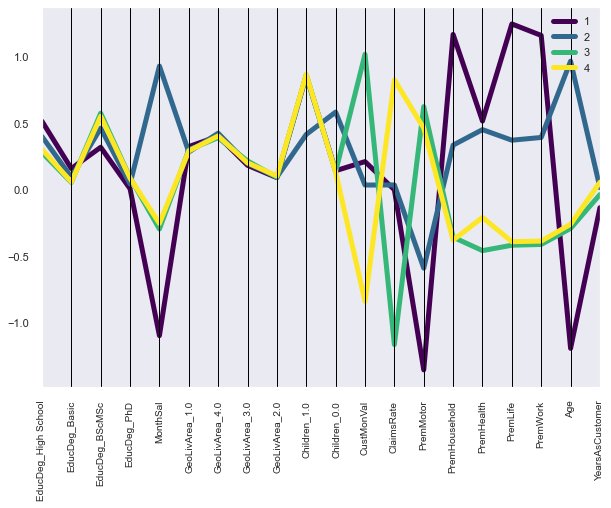

In [152]:
plt.figure(figsize=(10, 7))

# We need to define the centroids of our clusters.
centroids = X_hc.groupby('hc_labels', as_index=False).mean()
pd.plotting.parallel_coordinates(centroids, class_column = "hc_labels", colormap="viridis",lw=5)

plt.xticks(fontsize=10, rotation=90)
plt.show()

**Clusters R²:**

In [153]:
r2_hc =  get_r2(X_hc, "hc_labels")
print("Cluster solution with R^2 of %0.4f" % r2_hc);

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_hc[num_vars + ['hc_labels']], 'hc_labels').drop('hc_labels').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R^2 of 0.3613


ClaimsRate         0.581339
CustMonVal         0.512966
Age                0.473636
PremMotor          0.469583
MonthSal           0.429393
PremLife           0.301117
PremWork           0.281817
PremHousehold      0.258423
PremHealth         0.157417
YearsAsCustomer    0.003412
dtype: float64

## __Visualization Hierarchical clusters using TSNE:__

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000283314A4F70>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000283314A4F70> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


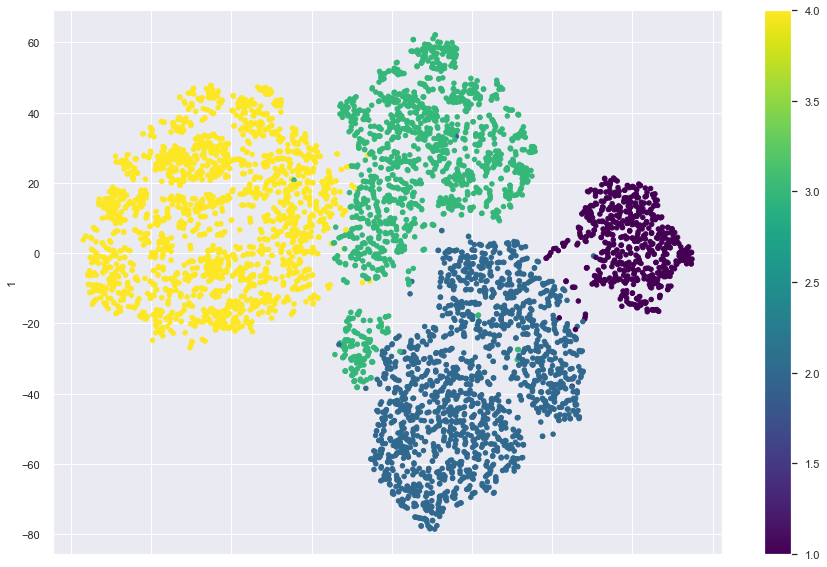

In [154]:
Tsne_hc = TSNE(perplexity=30, random_state=random_state).fit_transform(X_hc)

pd.DataFrame(Tsne_hc).plot.scatter(x=0, y=1, c = X_hc['hc_labels'],
                                      colormap='viridis', figsize=(15,10))
plt.show();

___

# **7. Density Based Clustering:**


## **7.1 Mean Shift Clustering:**

What is Mean-shift clustering? How does it work?
 
### _Characteristics:_
- No need to define number of clusters apriori..
- Can detect clusters of any shape.
- Robust to outliers.
- Depends on the bandwidth hyperparameter (but there's a way to estimate it).
- **Main drawback**: Poor scalability (on both the algorithm and in estimating the bandwidth).

In [155]:
# The following bandwidth can be automatically detected using (we need to set a quantile).
# Based on distance to nearest neighbors for all observations.

bandwidth = estimate_bandwidth(X[num_vars], quantile=0.06, n_samples=50, 
                               random_state=random_state, n_jobs=-1)
bandwidth

2.3654666426983453

In [156]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms_labels = ms.fit_predict(X[num_vars])

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 2


In [157]:
# Concatenating the labels to X
X_ms = pd.concat([X, pd.Series(ms_labels, index=X.index, name="ms_labels")], axis=1)

In [158]:
# Concatenating the labels to X
X_beforeNorm_ms = pd.concat([X_beforeNorm, pd.Series(ms_labels, index=X_beforeNorm.index, name="ms_labels")], axis=1)
X_beforeNorm_ms.groupby('ms_labels').mean().T

ms_labels                      0            1
EducDeg_High School     0.359869     0.335954
EducDeg_Basic           0.075367     0.082202
EducDeg_BScMSc          0.497553     0.517870
EducDeg_PhD             0.067210     0.063974
MonthSal             2605.666558  2544.730879
GeoLivArea_1.0          0.285808     0.303788
GeoLivArea_4.0          0.421533     0.391351
GeoLivArea_3.0          0.194127     0.210508
GeoLivArea_2.0          0.098532     0.094353
Children_1.0            0.726591     0.736955
Children_0.0            0.273409     0.263045
CustMonVal             35.139396   386.853156
ClaimsRate              0.919648     0.429317
PremMotor             317.329993   314.369417
PremHousehold         160.908646   179.361741
PremHealth            173.146600   171.059911
PremLife               33.480741    34.577034
PremWork               33.417426    34.406505
Age                    50.121370    48.912437
YearsAsCustomer        30.069494    29.830951

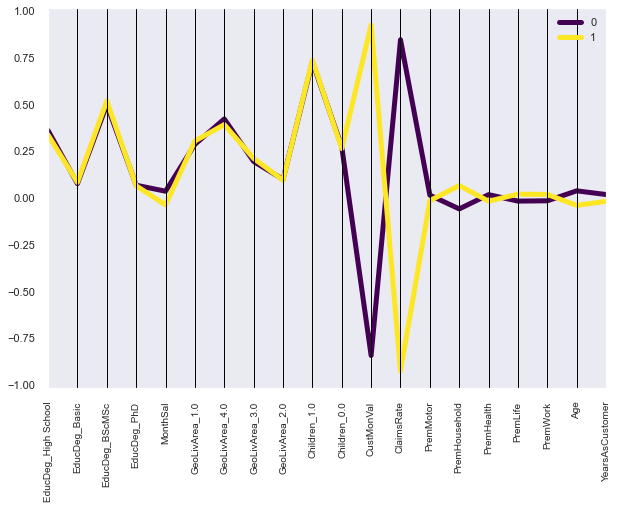

In [159]:
plt.figure(figsize=(10, 7))

# We need to define the centroids of our clusters.
centroids = X_ms.groupby('ms_labels', as_index=False).mean()
pd.plotting.parallel_coordinates(centroids, class_column = "ms_labels", colormap="viridis", lw=5)

plt.xticks(fontsize=10, rotation=90)
plt.show();

**Clusters R²:**

In [160]:
r2_ms =  get_r2(X_ms[num_vars + ["ms_labels"]], "ms_labels")
print("Cluster solution with R^2 of %0.4f" % r2_ms);

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_ms[num_vars + ['ms_labels']], 'ms_labels').drop('ms_labels').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R^2 of 0.1776


ClaimsRate         0.782444
CustMonVal         0.779888
PremHousehold      0.003889
Age                0.001510
MonthSal           0.001345
PremLife           0.000346
YearsAsCustomer    0.000328
PremHealth         0.000305
PremWork           0.000286
PremMotor          0.000214
dtype: float64

### Visualization Mean shift clusters using TSNE:

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002832F821B50>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002832F821B50> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


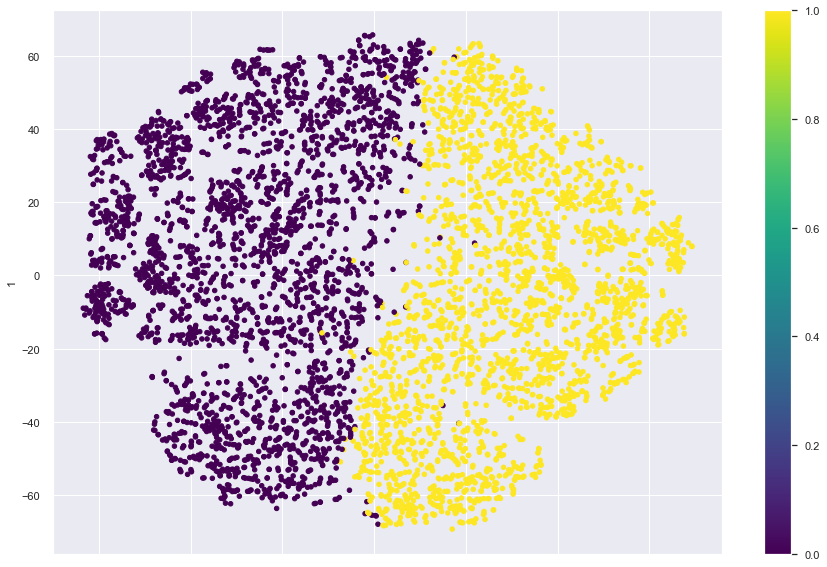

In [161]:
Tsne_ms = TSNE(perplexity=30, random_state=random_state).fit_transform(X_ms)

pd.DataFrame(Tsne_ms).plot.scatter(x=0, y=1, c = X_ms['ms_labels'],
                                      colormap='viridis', figsize=(15,10))
plt.show();

___

## **7.2 DBSCAN (Density-based spatial clustering of applications with noise):**

### Characteristics:
- No need to define number of clusters apriori.
- Resistant to noise and outliers.
- Can identify outliers.
- Can handle clusters of different shapes and sizes.
- Depends highly on the epsilon hyperparameter and it can be hard to tune.
- Does not work well with clusters of varying densities.

### Defining eps and min_samples:
- **MinPts**: As a rule of thumb, **minPts = 2 x dim** can be used, but it may be necessary to choose larger values for very large data, for noisy data or for data that contains many duplicates.

- **ε**: The value for ε can then be chosen by using a **k-distance graph**, plotting the distance to the kth (k = minPts - 1) nearest neighbor ordered from the largest to the smallest value. Good values of ε are where this plot shows an **"elbow"**: if ε is chosen much too small, a large part of the data will not be clustered; whereas for a too high value of ε, clusters will merge and the majority of objects will be in the same cluster. **The assumption is that for points in a cluster, their k nearest neighbors are at roughly the same distance**. Noise points have their k-th nearest neighbors at farther distance

In [162]:
# Perform DBSCAN clustering.

dbscan = DBSCAN(eps=2.4, min_samples=15, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X[num_vars])
Counter(dbscan_labels)

Counter({0: 5860, -1: 3})

In [163]:
dbscan_n_clusters = len(np.unique(dbscan_labels)) - int(-1 in dbscan_labels)
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 1


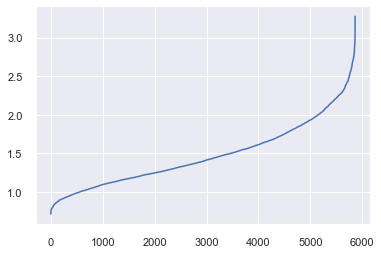

In [164]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(X[num_vars])
distances, _ = neigh.kneighbors(X[num_vars])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [165]:
# Concatenating the labels to X
X_dbscan = pd.concat([X, pd.Series(dbscan_labels, index=X.index, name="dbscan_labels")], axis=1)

In [166]:
# Concatenating the labels to X
X_beforeNorm_dbscan = pd.concat([X_beforeNorm, pd.Series(dbscan_labels, index=X_beforeNorm.index, name="dbscan_labels")], axis=1)
X_beforeNorm_dbscan.groupby('dbscan_labels').mean().T

dbscan_labels                 -1            0
EducDeg_High School     0.333333     0.348464
EducDeg_Basic           0.000000     0.078669
EducDeg_BScMSc          0.666667     0.507167
EducDeg_PhD             0.000000     0.065700
MonthSal             1363.333333  2577.207338
GeoLivArea_1.0          0.000000     0.294539
GeoLivArea_4.0          0.666667     0.406997
GeoLivArea_3.0          0.333333     0.201877
GeoLivArea_2.0          0.000000     0.096587
Children_1.0            0.333333     0.731741
Children_0.0            0.666667     0.268259
CustMonVal            387.893333   202.893123
ClaimsRate              0.500000     0.685742
PremMotor             151.473333   316.001304
PremHousehold         410.816667   169.591587
PremHealth            111.983333   172.181572
PremLife              125.023333    33.957328
PremWork              120.690000    33.845007
Age                    26.333333    49.556314
YearsAsCustomer        31.333333    29.954949

In [167]:
# Detecting noise (potential outliers)
X_dbscan.loc[X_dbscan['dbscan_labels'] == -1].head(2)

EducDeg_High School  EducDeg_Basic  EducDeg_BScMSc  EducDeg_PhD  \
5129                    1              0               0            0   
5377                    0              0               1            0   

      MonthSal  GeoLivArea_1.0  GeoLivArea_4.0  GeoLivArea_3.0  \
5129 -1.616630               0               1               0   
5377 -0.956282               0               1               0   

      GeoLivArea_2.0  Children_1.0  ...  CustMonVal  ClaimsRate  PremMotor  \
5129               0             0  ...   -0.460059    0.665838  -2.028432   
5377               0             0  ...    1.312004   -1.681806  -0.686943   

      PremHousehold  PremHealth  PremLife  PremWork       Age  \
5129       2.844455   -0.875359  3.480368  3.143637 -1.579403   
5377      -0.719699   -1.569905  3.582266  2.367321 -1.064613   

      YearsAsCustomer  dbscan_labels  
5129        -1.056683             -1  
5377         0.006737             -1  

[2 rows x 21 columns]

In [168]:
r2_dbscan =  get_r2(X_dbscan, "dbscan_labels")
print("Cluster solution with R^2 of %0.4f" % r2_dbscan)

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_dbscan[num_vars + ['dbscan_labels']], 'dbscan_labels').drop('dbscan_labels').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R^2 of 0.0014


PremLife           0.004893
PremWork           0.004523
PremHousehold      0.001362
PremMotor          0.001355
Age                0.001142
MonthSal           0.001094
PremHealth         0.000520
CustMonVal         0.000442
ClaimsRate         0.000230
YearsAsCustomer    0.000022
dtype: float64

- Why did the DBSCAN gave us just one cluster?
- What can we do with the noisy data?

___

## **7.3 GMM (Gaussian Mixture Model):**
What is GMM? How does it work?
![](../figures/gmm.gif)

--- 

$$\mathcal{p(\vec{x})} \ = \ \sum_{i=1}^K \phi_i \mathcal{N}(\vec{x}|\vec{\mu_i}, \Sigma_i) \tag{eq1}$$
$$\mathcal{N}(\vec{x}|\vec{\mu_i}, \Sigma_i) \ = \ \frac{1}{\sqrt{{(2\pi)}^{K}|\Sigma_i|}}e^{-\frac{1}{2} (\vec{x} - \vec{\mu_i})^T \Sigma_i^{-1} (\vec{x} - \vec{\mu_i})} \tag{eq2}$$
$$\sum_{i=1}^K \phi_i \ = \ 1 \tag{eq3}$$

, where:
- $\phi_i$ is the component weight (scalar) for Component $i$ (probability of an observation being generated by Component $i$)
- $\vec{\mu_i}$ is the mean vector for Component $i$,
- $\Sigma_i$ is the Covariance matrix for Component $i$

---

- **(eq1)** gives the probability of a point $x$ given the estimated Gaussian mixture
- **(eq2)** is the probability density function of a multivariate Gaussian with mean $\vec{\mu_i}$ and covariance $\Sigma_i$
- **(eq3)** states that the sum of the component weights is 1, such that the total probability distribution normalizes to 1

### Characteristics:
- Assumes the data is generated from a mixture of finite number of Gaussian distributions with unknown parameters
- Use the EM (Expectation Maximization algorithm) to estimate the parameters
- Provides a probability of each observation belonging to each cluster
- Advantages over K-Means:
    - Can deal with spherical and elipsoid cluster shapes
    - Number of components needs to be defined apriori

In [169]:
# Performing GMM clustering:
n_components=3
gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=20,
                      init_params='kmeans', random_state=random_state)
gmm_labels = gmm.fit_predict(X[num_vars])
labels_proba = gmm.predict_proba(X[num_vars])

**Let's look at the estimated parameters:**

In [170]:
# The estimated component weights
gmm.weights_

array([0.30987, 0.2589 , 0.43123])

In [171]:
# The estimated mean vectors of the Components
gmm.means_

array([[ 0.03723, -1.02546,  1.00588,  0.53186, -0.61961, -0.20207,
        -0.43707, -0.38424,  0.03771,  0.0079 ],
       [-0.00326,  1.00408, -1.21485,  0.5708 , -0.57121, -0.26169,
        -0.44344, -0.43266, -0.01219, -0.01423],
       [-0.0248 ,  0.13405,  0.00657, -0.72488,  0.78819,  0.30232,
         0.58031,  0.53587, -0.01978,  0.00287]])

In [172]:
# The estimated covariance matrices of the Components
gmm.covariances_.shape

(3, 10, 10)

### __Defining covariance_type:__
This hyperparameter controls the **degrees of freedom** in the shape of each cluster The more degrees of freedom we have the more complex shapes the model can fit and the more computationally expensive the model will be.

- `covariance_type="tied"` makes all components share the same general covariance matrix

### __Defining the number of clusters:__

- **AIC**: estimates the relative amount of information lost by a model used to represent the data-generation process. The smaller the better.

- **BIC**: similar to AIC but penalizes more complex models (i.e. favors simpler models). The smaller the better.

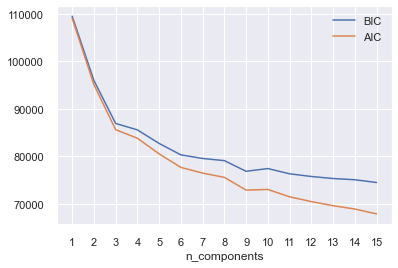

In [173]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n_components=n, covariance_type='full', 
                          n_init=20, random_state=random_state).fit(X[num_vars])
          for n in n_components]

bic_values = [m.bic(X[num_vars]) for m in models]
aic_values = [m.aic(X[num_vars]) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

**Note**: the AIC and BIC measures can also be used to select diferent hyperparameters such as the covariance_type

- The plot above shows that the best fit for the parameter n_components is 3.

**Silhouette Coefficient formula for a single sample:**
$$s = \frac{b - a}{max(a, b)}$$
, where:
- $a$: The mean distance between a sample and all other points in the same cluster.
- $b$: The mean distance between a sample and all other points in the next nearest cluster

For n_clusters = 2, the average silhouette_score is : 0.1549878319965508
For n_clusters = 3, the average silhouette_score is : 0.1558624086687324
For n_clusters = 4, the average silhouette_score is : 0.17428361287944147
For n_clusters = 5, the average silhouette_score is : 0.13319502092927019
For n_clusters = 6, the average silhouette_score is : 0.11829936214464745
For n_clusters = 7, the average silhouette_score is : 0.08479668589755178
For n_clusters = 8, the average silhouette_score is : 0.09546979271619352
For n_clusters = 9, the average silhouette_score is : 0.06938604177637282
For n_clusters = 10, the average silhouette_score is : 0.06361077722274644


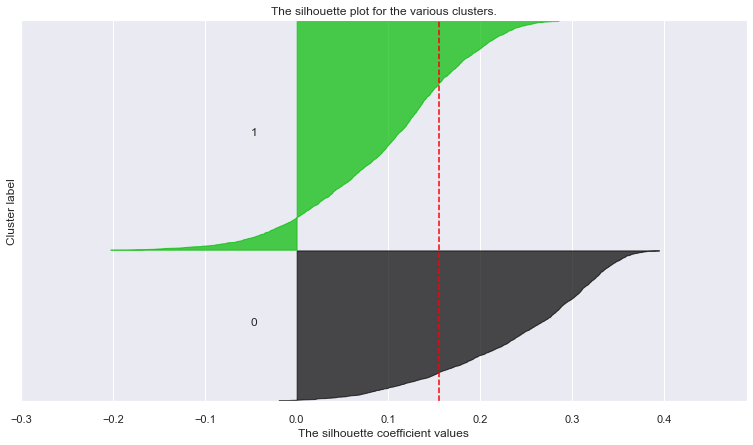

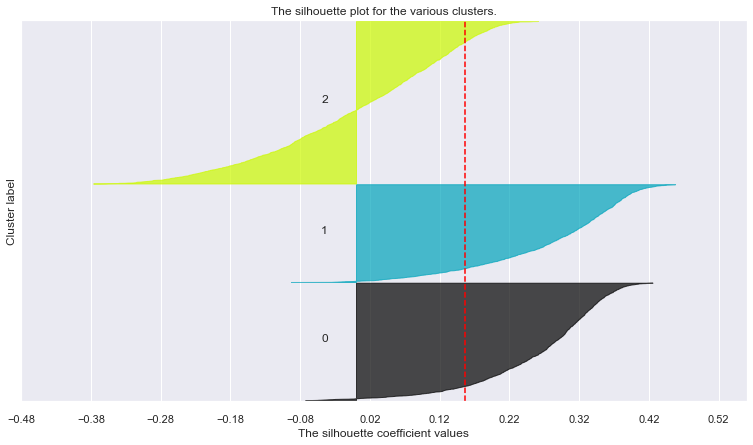

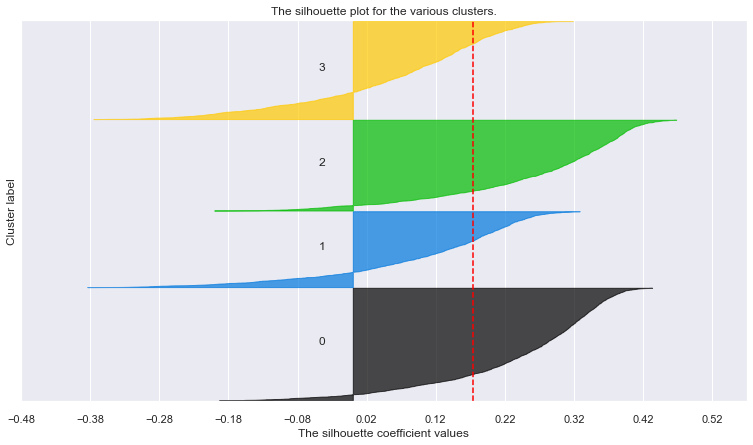

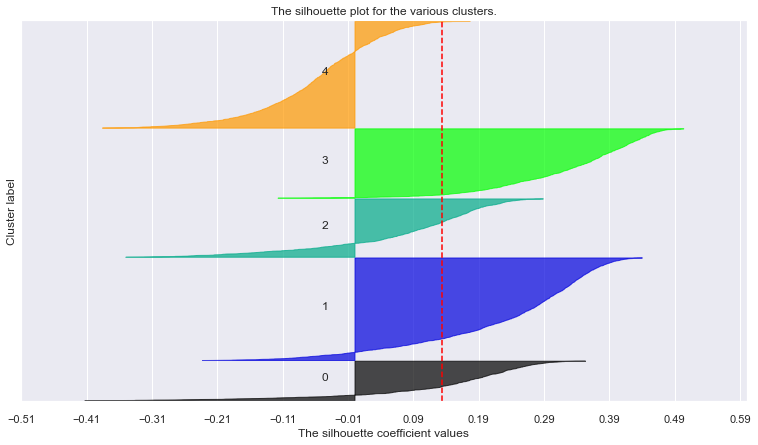

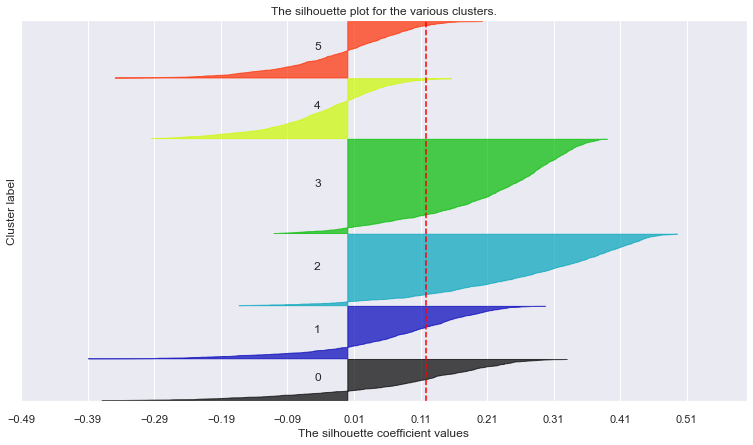

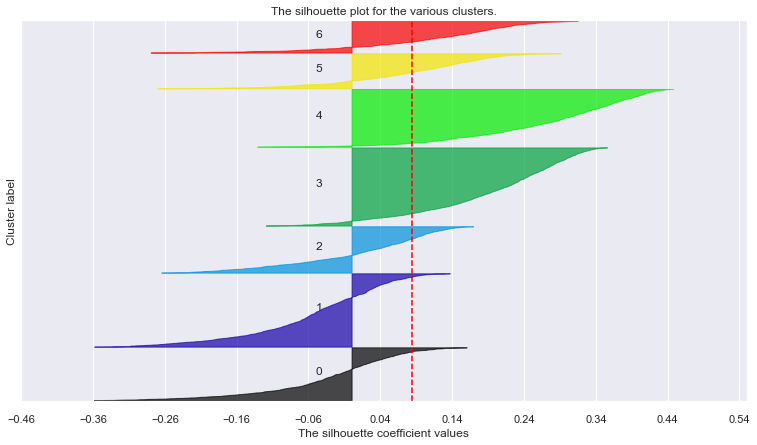

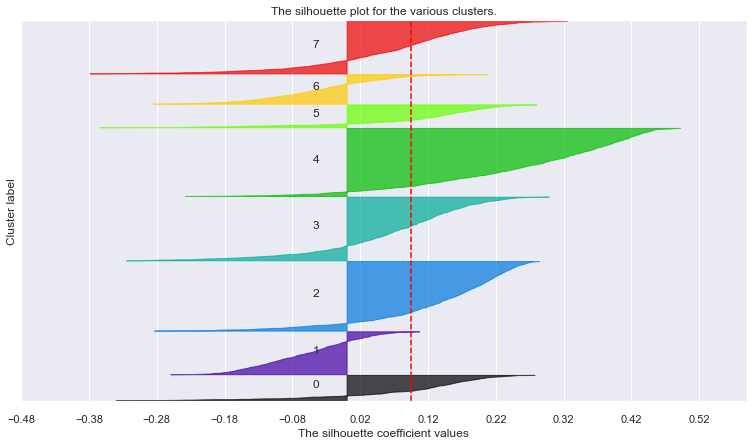

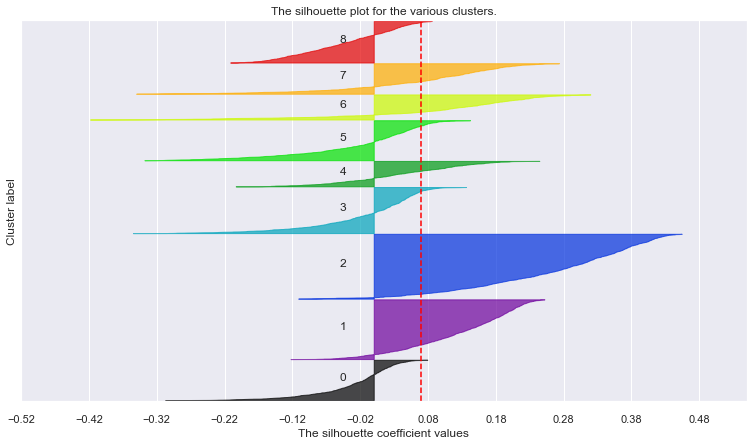

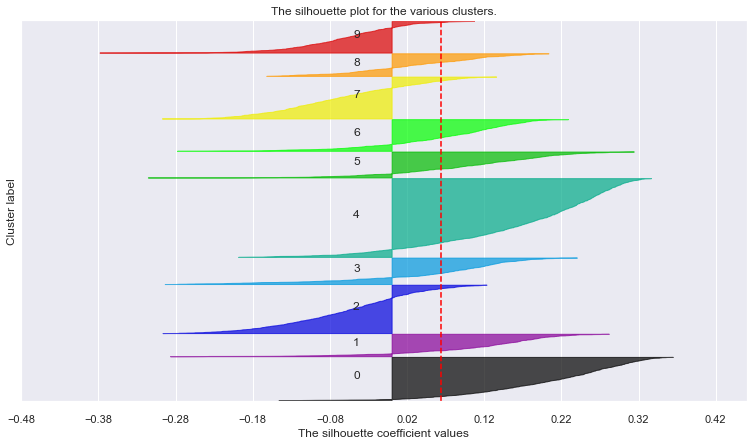

In [174]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.htmlsphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the gmm object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    gmmclust = GaussianMixture(n_components=nclus, covariance_type='full', n_init=20, 
                      init_params='kmeans', random_state=random_state)
    cluster_labels = gmmclust.fit_predict(X[num_vars])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X[num_vars], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X[num_vars], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(X[num_vars]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

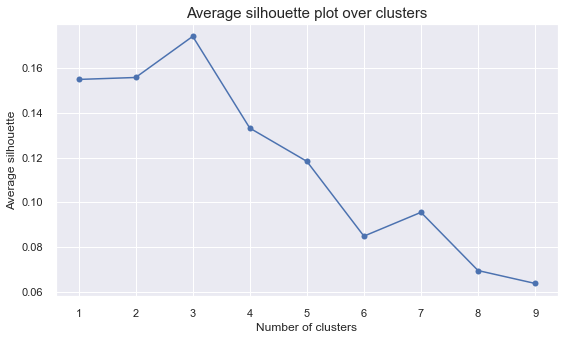

In [175]:
# The average silhouette plot
plt.figure(figsize=(9,5))
plt.plot(range(1,10), avg_silhouette, marker=".", markersize=12)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

#### __Final Gaussian Mixture Model clustering solution:__

In [176]:
# Performing GMM clustering
n_components=3
gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=20, 
                      init_params='kmeans', random_state=random_state)
gmm_labels = gmm.fit_predict(X[num_vars])

In [177]:
# Concatenating the labels to X
X_gmm = pd.concat([X, pd.Series(gmm_labels, index=X.index, name="gmm_labels")], axis=1)

In [178]:
# Concatenating the labels to X
X_beforeNorm_gmm = pd.concat([X_beforeNorm, pd.Series(gmm_labels, 
                              index=X_beforeNorm.index, name="gmm_labels")], axis=1)
X_beforeNorm_gmm.groupby('gmm_labels').mean().T

gmm_labels                     0            1            2
EducDeg_High School     0.284696     0.253623     0.451626
EducDeg_Basic           0.050466     0.048748     0.116971
EducDeg_BScMSc          0.571585     0.600791     0.404441
EducDeg_PhD             0.093253     0.096838     0.026963
MonthSal             2607.726275  2574.666667  2555.232355
GeoLivArea_1.0          0.287438     0.306983     0.291832
GeoLivArea_4.0          0.411410     0.397233     0.409992
GeoLivArea_3.0          0.197477     0.204216     0.203807
GeoLivArea_2.0          0.103675     0.091568     0.094370
Children_1.0            0.775645     0.788538     0.665345
Children_0.0            0.224355     0.211462     0.334655
CustMonVal             -0.836380   403.379960   229.703140
ClaimsRate              0.963889     0.348103     0.687692
PremMotor             369.531404   373.943445   242.236384
PremHousehold          77.965442    84.922793   287.071907
PremHealth            160.234218   156.420184   190.232807
PremLife               21.149786    20.803511    51.240769
PremWork               22.697510    21.177905    49.630527
Age                    50.135491    49.344532    49.237510
YearsAsCustomer        30.009874    29.879447    29.962331

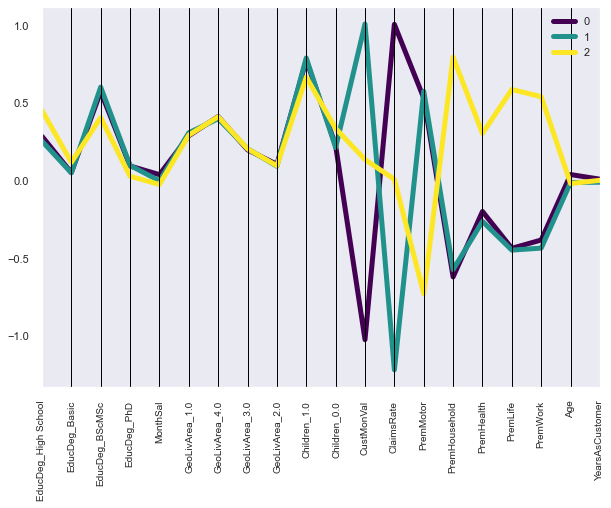

In [179]:
plt.figure(figsize=(10, 7))

# We need to define the centroids of our clusters.
centroids = X_gmm.groupby('gmm_labels', as_index=False).mean()
pd.plotting.parallel_coordinates(centroids, class_column = "gmm_labels", colormap="viridis", lw=5)

plt.xticks(fontsize=10, rotation=90)
plt.show()

**Clusters R²:**

In [180]:
r2_gmm =  get_r2(X_gmm, "gmm_labels")
print("Cluster solution with R^2 of %0.4f" % r2_gmm);

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_gmm[num_vars + ['gmm_labels']], 'gmm_labels').drop('gmm_labels').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R^2 of 0.2797


ClaimsRate         0.698852
CustMonVal         0.596932
PremHousehold      0.476294
PremMotor          0.401468
PremLife           0.258766
PremWork           0.219720
PremHealth         0.069874
MonthSal           0.000724
Age                0.000660
YearsAsCustomer    0.000056
dtype: float64

### Visualization Gaussian Mixture Model clusters using TSNE:

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000028334B60D00>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000028334B60D00> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


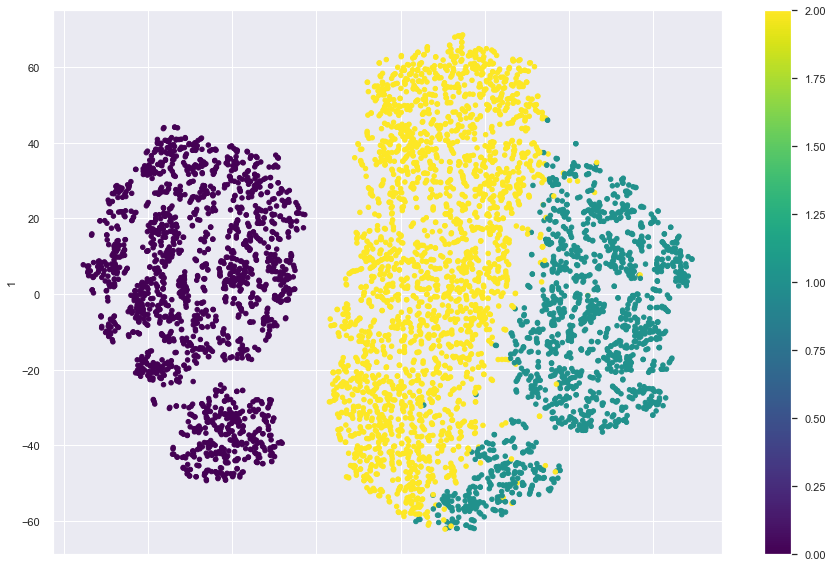

In [181]:
Tsne_gmm = TSNE(perplexity=30, random_state=random_state).fit_transform(X_gmm)
pd.DataFrame(Tsne_gmm).plot.scatter(x=0, y=1, c = X_gmm['gmm_labels'],
                                      colormap='viridis', figsize=(15,10))
plt.show();

___

# **8. Clustering by perspectives:**
We split the variables into perspectives.

In [182]:
# Split variables into perspectives (example, requires critical thinking and domain knowledge)
demographic_features = [
    'MonthSal',
    'Age',
    'YearsAsCustomer', 
    'CustMonVal',
    'ClaimsRate',  
]

Prem_features = [
    'PremMotor',
    'PremHousehold',
    'PremHealth',
    'PremLife',
    'PremWork', 
]

X_perspective = X.copy(deep=True)
X_dem = X_perspective[demographic_features].copy(deep=True)
X_prm = X_perspective[Prem_features].copy(deep=True)

## **Testing on K-means and Hierarchical clustering:**
INSERT COMMENT HERE.

In [183]:
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = get_r2(df, labels)
    return r2_clust

In [184]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=random_state
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

### **Finding the optimal clusters on demographic variables:**

In [185]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(X_dem, kmeans)

for link in ['complete', 'average', 'single', 'ward']:
    r2_scores[link] = get_r2_scores(
        X_dem, hierarchical.set_params(linkage=link)
    )

pd.DataFrame(r2_scores)

kmeans  complete   average    single      ward
2  0.313518  0.259477  0.284047  0.000191  0.289734
3  0.496316  0.435657  0.427941  0.000430  0.426742
4  0.607116  0.539737  0.560113  0.000586  0.543426
5  0.655176  0.599451  0.598634  0.000832  0.596831
6  0.693395  0.629011  0.632866  0.001031  0.631501
7  0.726756  0.653976  0.679766  0.001261  0.666093
8  0.756499  0.683729  0.715860  0.001450  0.695519
9  0.772612  0.705645  0.731765  0.001770  0.718296

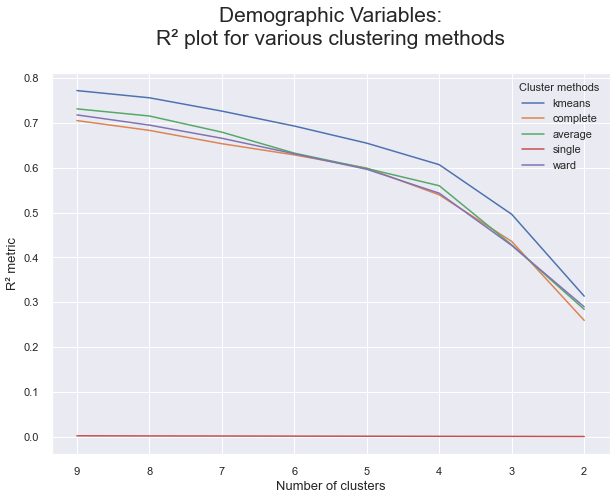

In [186]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.gca().invert_xaxis()  # invert x axis
plt.ylabel("R² metric", fontsize=13)
plt.show();

### **Repeat the process for premium variables:**

In [187]:
# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(X_prm, kmeans)

for link in ['complete', 'average', 'single', 'ward']:
    r2_scores[link] = get_r2_scores(
        X_prm, hierarchical.set_params(linkage=link)
    )

pd.DataFrame(r2_scores)

kmeans  complete   average    single      ward
2  0.387064  0.133169  0.274021  0.000534  0.320475
3  0.509812  0.339690  0.314042  0.000799  0.451118
4  0.564009  0.404528  0.325455  0.001240  0.511085
5  0.607789  0.437791  0.355987  0.001718  0.551477
6  0.643076  0.502059  0.370035  0.002389  0.584041
7  0.673826  0.566899  0.388528  0.002814  0.613599
8  0.694738  0.577733  0.584244  0.003610  0.631508
9  0.712568  0.622170  0.604257  0.004804  0.648635

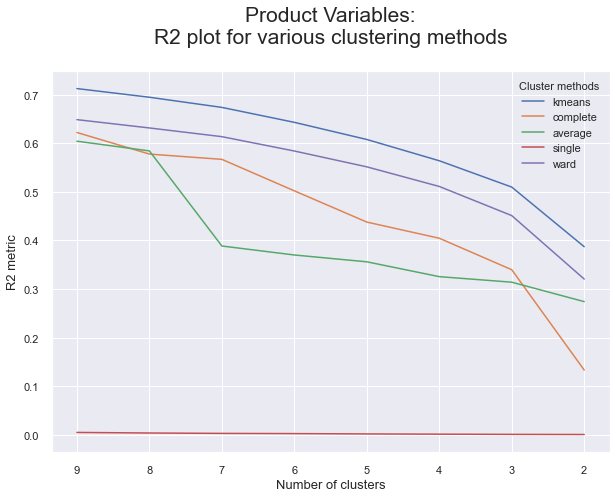

In [188]:
# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Product Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.gca().invert_xaxis()  # invert x axis
plt.ylabel("R2 metric", fontsize=13)
plt.show()

## **Merging the Perspectives:**
- How can we merge different cluster solutions?

In [189]:
# Applying the right clustering (algorithm and number of clusters) for each perspective

kmeans_dem = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=random_state
)
dem_labels = kmeans_dem.fit_predict(X_dem)


kmeans_prm = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=random_state
)

prm_labels = kmeans_prm.fit_predict(X_prm)

X_dem['dem_labels'] = dem_labels
X_prm['prm_labels'] = prm_labels

X_perspective["dem_labels"] = dem_labels
X_perspective["prm_labels"] = prm_labels

In [190]:
# Counting label frequencies (contigency table)
X_perspective.groupby(['prm_labels', 'dem_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('dem_labels', 'prm_labels', 0)

prm_labels    0    1    2
dem_labels               
0           511  561  341
1           579  603  373
2           477  545  308
3           563  644  358

### **Manual merging: Merge lowest frequency clusters into closest clusters:**

In [191]:
# Clusters with low frequency to be merged:
to_merge = [(0,0), (1,0), (2,0), (3,2)]

X_perspective_centroids = X_perspective.groupby(['dem_labels', 'prm_labels'])\
    [num_vars].mean()

# Computing the euclidean distance matrix between the centroids
euclidean = pairwise_distances(X_perspective_centroids)
df_dists = pd.DataFrame(
    euclidean, columns=X_perspective_centroids.index, index=X_perspective_centroids.index
)

# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}
for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(0, 0): (3, 0), (1, 0): (2, 0), (3, 2): (3, 0)}

In [192]:
X_ = X_perspective.copy()

# Changing the dem_labels and prm_labels based on source_target.
for source, target in source_target.items():
    mask = (X_['dem_labels']==source[0]) & (X_['prm_labels']==source[1])
    X_.loc[mask, 'dem_labels'] = target[0]
    X_.loc[mask, 'prm_labels'] = target[1]

# New contigency table
X_.groupby(['prm_labels', 'dem_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('dem_labels', 'prm_labels', 0)

prm_labels       0      1      2
dem_labels                      
0              NaN  561.0  341.0
1              NaN  603.0  373.0
2           1056.0  545.0  308.0
3           1432.0  644.0    NaN

### **Merging using Hierarchical clustering:**

In [193]:
# Centroids of the concatenated cluster labels
X_perspective_centroids = X_perspective.groupby(['dem_labels', 'prm_labels'])\
    [num_vars].mean()
X_perspective_centroids

MonthSal  CustMonVal  ClaimsRate  PremMotor  \
dem_labels prm_labels                                                
0          0           0.918250    0.674622   -0.687688  -0.317741   
           1           0.693959    1.085458   -1.261078   0.923799   
           2           0.916560    1.010427   -0.662993  -0.996141   
1          0          -0.903264   -0.782920    0.769075  -0.368507   
           1          -0.603585   -0.971001    0.954179   1.052155   
           2          -1.101911   -0.638032    0.701277  -1.319531   
2          0          -0.951343    0.732832   -0.765085  -0.261383   
           1          -0.698354    1.087481   -1.318642   0.967778   
           2          -1.162911    1.114611   -0.729615  -1.245435   
3          0           0.966887   -0.794835    0.781375  -0.378926   
           1           0.703070   -0.968958    0.955451   1.007962   
           2           0.900324   -0.657699    0.714566  -1.117478   

                       PremHousehold  PremHealth  PremLife  PremWork  \
dem_labels prm_labels                                                  
0          0               -0.051247    0.652836 -0.116414 -0.091089   
           1               -0.429759   -0.882298 -0.434549 -0.464975   
           2                1.158414    0.090530  1.068008  1.053184   
1          0               -0.241842    0.822917 -0.127492 -0.077164   
           1               -0.631110   -0.826000 -0.640279 -0.635459   
           2                1.155567    0.477301  1.250974  1.145314   
2          0               -0.122896    0.697930 -0.199072 -0.171931   
           1               -0.558740   -0.783257 -0.581922 -0.588838   
           2                1.247096    0.340642  1.135611  1.167130   
3          0               -0.147387    0.750461 -0.103716 -0.033784   
           1               -0.531967   -0.899478 -0.550268 -0.547996   
           2                1.023514    0.334845  1.138192  1.017598   

                            Age  YearsAsCustomer  
dem_labels prm_labels                             
0          0           0.965709        -0.007236  
           1           0.655368        -0.004637  
           2           0.942652        -0.154536  
1          0          -0.964700         0.045307  
           1          -0.546515        -0.018709  
           2          -1.175196        -0.106488  
2          0          -0.971125         0.083492  
           1          -0.658567         0.013706  
           2          -1.237185        -0.115586  
3          0           1.039122         0.063942  
           1           0.665808         0.050142  
           2           0.930916         0.010556

In [194]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(X_perspective_centroids)

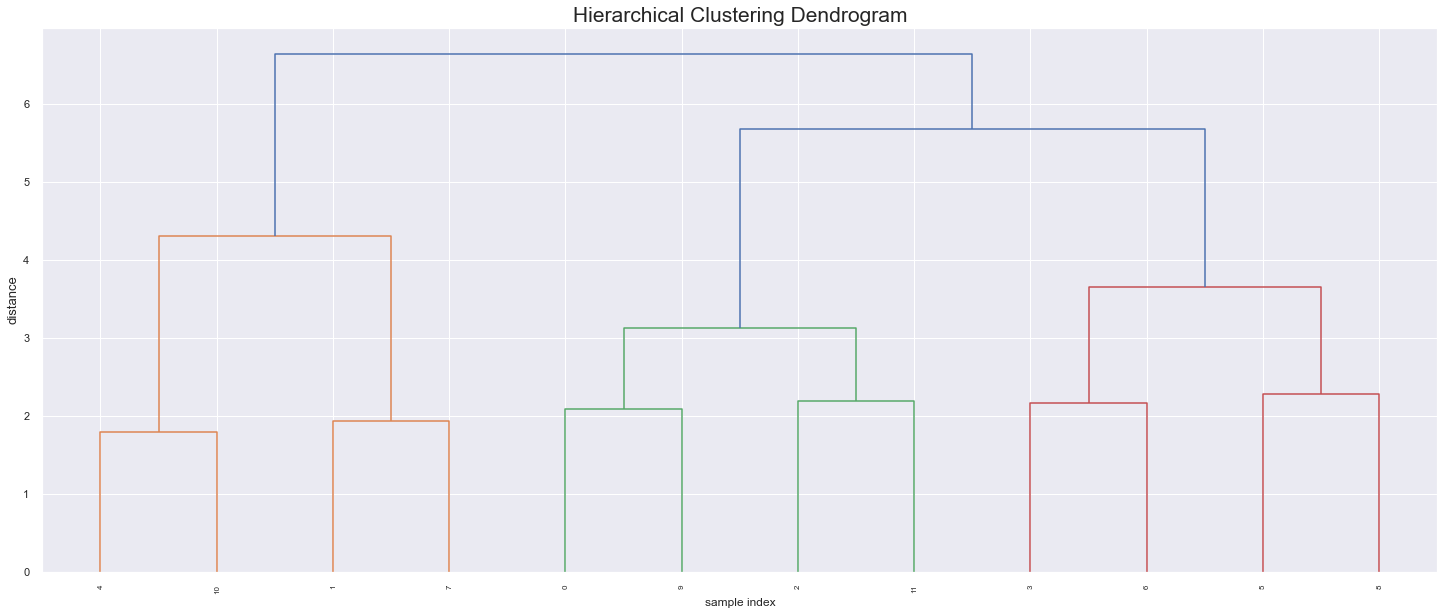

In [195]:
linked = linkage(X_perspective_centroids, method="ward", metric="euclidean")

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram', fontsize=21)
plt.xlabel('sample index')
plt.ylabel('distance', fontsize=13)
dendrogram(
    linked,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

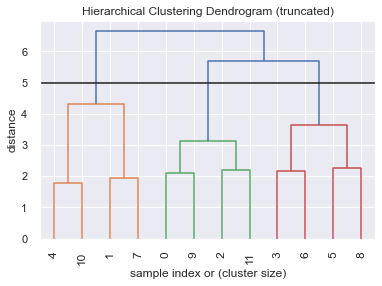

In [196]:
max_d = 5

fancy_dendrogram(
    linked,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [197]:
# Re-running the Hierarchical clustering based on the correct number of clusters

nclust=3

hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=nclust
)

hclust_labels = hclust.fit_predict(X_perspective_centroids)
X_perspective_centroids['hclust_labels'] = hclust_labels

X_perspective_centroids  # centroid's cluster labels

MonthSal  CustMonVal  ClaimsRate  PremMotor  \
dem_labels prm_labels                                                
0          0           0.918250    0.674622   -0.687688  -0.317741   
           1           0.693959    1.085458   -1.261078   0.923799   
           2           0.916560    1.010427   -0.662993  -0.996141   
1          0          -0.903264   -0.782920    0.769075  -0.368507   
           1          -0.603585   -0.971001    0.954179   1.052155   
           2          -1.101911   -0.638032    0.701277  -1.319531   
2          0          -0.951343    0.732832   -0.765085  -0.261383   
           1          -0.698354    1.087481   -1.318642   0.967778   
           2          -1.162911    1.114611   -0.729615  -1.245435   
3          0           0.966887   -0.794835    0.781375  -0.378926   
           1           0.703070   -0.968958    0.955451   1.007962   
           2           0.900324   -0.657699    0.714566  -1.117478   

                       PremHousehold  PremHealth  PremLife  PremWork  \
dem_labels prm_labels                                                  
0          0               -0.051247    0.652836 -0.116414 -0.091089   
           1               -0.429759   -0.882298 -0.434549 -0.464975   
           2                1.158414    0.090530  1.068008  1.053184   
1          0               -0.241842    0.822917 -0.127492 -0.077164   
           1               -0.631110   -0.826000 -0.640279 -0.635459   
           2                1.155567    0.477301  1.250974  1.145314   
2          0               -0.122896    0.697930 -0.199072 -0.171931   
           1               -0.558740   -0.783257 -0.581922 -0.588838   
           2                1.247096    0.340642  1.135611  1.167130   
3          0               -0.147387    0.750461 -0.103716 -0.033784   
           1               -0.531967   -0.899478 -0.550268 -0.547996   
           2                1.023514    0.334845  1.138192  1.017598   

                            Age  YearsAsCustomer  hclust_labels  
dem_labels prm_labels                                            
0          0           0.965709        -0.007236              2  
           1           0.655368        -0.004637              0  
           2           0.942652        -0.154536              2  
1          0          -0.964700         0.045307              1  
           1          -0.546515        -0.018709              0  
           2          -1.175196        -0.106488              1  
2          0          -0.971125         0.083492              1  
           1          -0.658567         0.013706              0  
           2          -1.237185        -0.115586              1  
3          0           1.039122         0.063942              2  
           1           0.665808         0.050142              0  
           2           0.930916         0.010556              2

In [198]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = X_perspective_centroids['hclust_labels'].to_dict()

#df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
X_['merged_labels'] = X_.apply(
    lambda row: cluster_mapper[
        (row['dem_labels'], row['prm_labels'])
    ], axis=1
)

# Merged cluster centroids
X_.groupby('merged_labels').mean().T

merged_labels               0         1         2
EducDeg_High School  0.267318  0.407024  0.398759
EducDeg_Basic        0.048024  0.105930  0.092499
EducDeg_BScMSc       0.586485  0.442142  0.465877
EducDeg_PhD          0.098173  0.044905  0.042865
MonthSal             0.041447 -1.005164  0.929750
GeoLivArea_1.0       0.298343  0.306851  0.276932
GeoLivArea_4.0       0.393115  0.397812  0.434856
GeoLivArea_3.0       0.214620  0.194013  0.192893
GeoLivArea_2.0       0.093923  0.101324  0.095319
Children_1.0         0.836379  0.910766  0.416808
Children_0.0         0.163621  0.089234  0.583192
CustMonVal          -0.003359  0.000901  0.003575
ClaimsRate          -0.100061  0.067475  0.066689
PremMotor            0.989914 -0.698805 -0.629127
PremHousehold       -0.539207  0.354913  0.367891
PremHealth          -0.849633  0.628861  0.511480
PremLife            -0.553077  0.372830  0.368744
PremWork            -0.560076  0.379959  0.371049
Age                  0.045888 -1.059982  0.977561
YearsAsCustomer      0.010998 -0.005333 -0.009372
dem_labels           1.540586  1.785262  2.423012
prm_labels           1.000000  0.784111  0.384659

In [199]:
X_beforeNorm_merged = X_beforeNorm.copy(deep=True)
X_beforeNorm_merged['merged_labels'] = X_['merged_labels']

In [200]:
# Merged cluster centroids:

X_beforeNorm_merged.groupby('merged_labels').mean().T

merged_labels                  0            1            2
EducDeg_High School     0.267318     0.407024     0.398759
EducDeg_Basic           0.048024     0.105930     0.092499
EducDeg_BScMSc          0.586485     0.442142     0.465877
EducDeg_PhD             0.098173     0.044905     0.042865
MonthSal             2610.981300  1742.434657  3348.153976
GeoLivArea_1.0          0.298343     0.306851     0.276932
GeoLivArea_4.0          0.393115     0.397812     0.434856
GeoLivArea_3.0          0.214620     0.194013     0.192893
GeoLivArea_2.0          0.093923     0.101324     0.095319
Children_1.0            0.836379     0.910766     0.416808
Children_0.0            0.163621     0.089234     0.583192
CustMonVal            202.319584   203.166960   203.699036
ClaimsRate              0.657943     0.704329     0.704112
PremMotor             415.964526   245.291111   252.333260
PremHousehold          90.024989   222.168020   224.086012
PremHealth            121.445321   209.680737   202.675510
PremLife               17.720697    44.980484    44.860186
PremWork               17.534101    44.985020    44.724811
Age                    50.257544    33.071963    64.736041
YearsAsCustomer        30.028049    29.920553    29.893965

INSERT COMMENT HERE.

In [201]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = X_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['dem_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['prm_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('dem_labels', 'prm_labels', 0)

prm_labels       1       2
dem_labels                
2              NaN  1737.0
3           2353.0  1773.0

## **Cluster Analysis:**

In [202]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        #ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction',
        #                fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

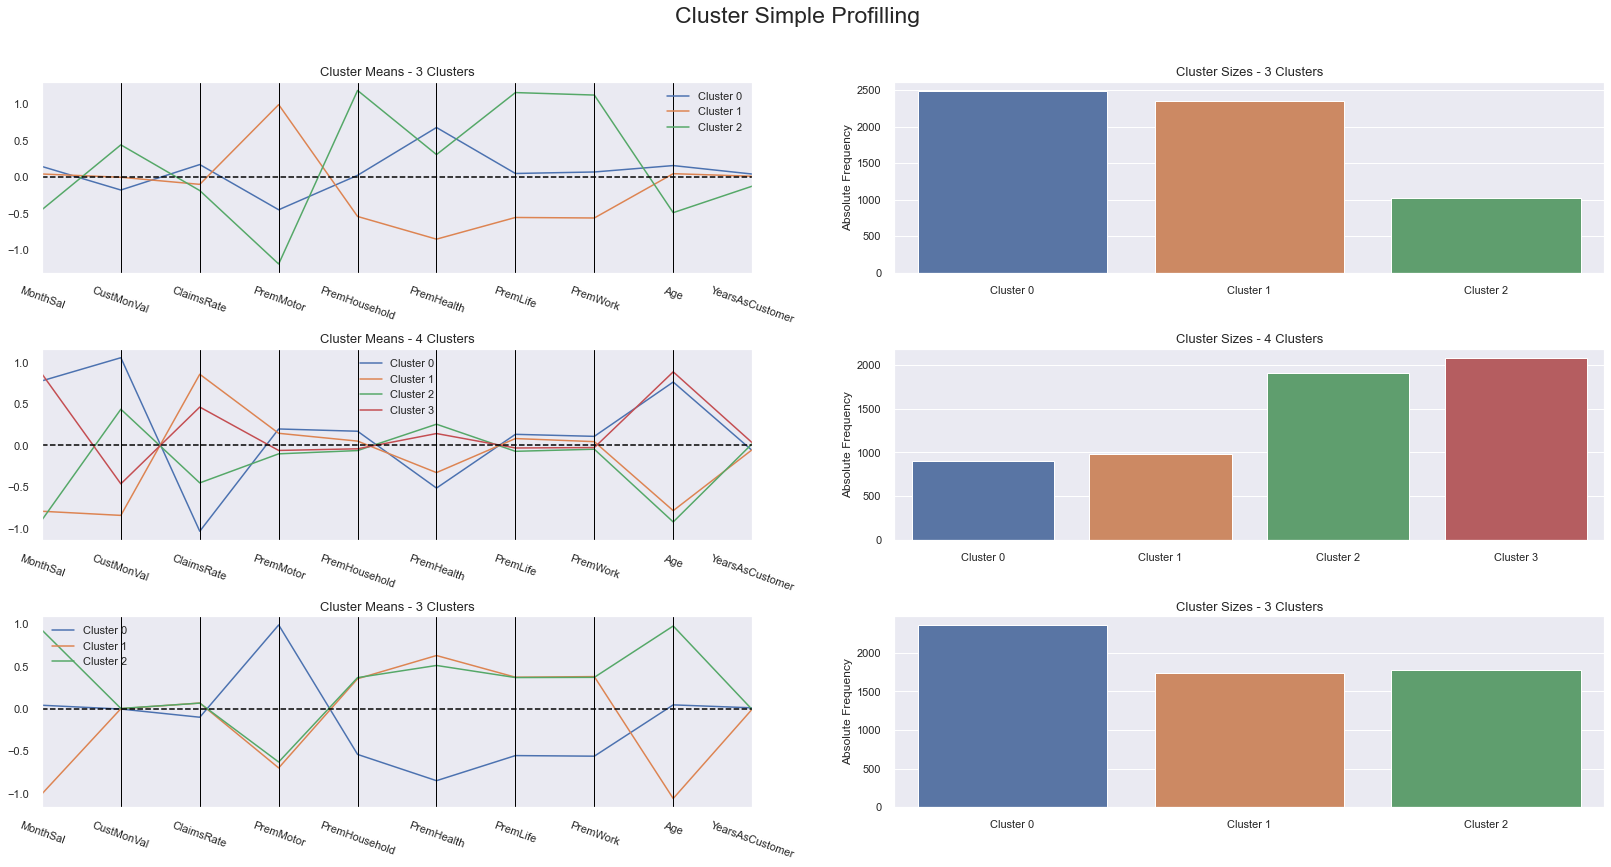

In [203]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = X_[num_vars + ['prm_labels', 'dem_labels', 'merged_labels']], 
    label_columns = ['prm_labels', 'dem_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["prm_labels", "dem_labels", "merged_labels"]
)

**Clusters R²:**

What proportion of each variables total SS is explained between clusters?

In [204]:
r2_merged =  get_r2(X_, "merged_labels")
print("Cluster solution with R^2 of %0.4f" % r2_merged);

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_[num_vars + ['merged_labels']], 'merged_labels').drop('merged_labels').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R^2 of 0.2805


PremMotor          0.657642
Age                0.622703
MonthSal           0.561431
PremHealth         0.485986
PremWork           0.210297
PremLife           0.205065
PremHousehold      0.194932
ClaimsRate         0.006712
YearsAsCustomer    0.000084
CustMonVal         0.000009
dtype: float64

## __Cluster visualization using t-SNE:__

In [205]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=random_state).fit_transform(X_[num_vars])

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002833285A9D0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002833285A9D0> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


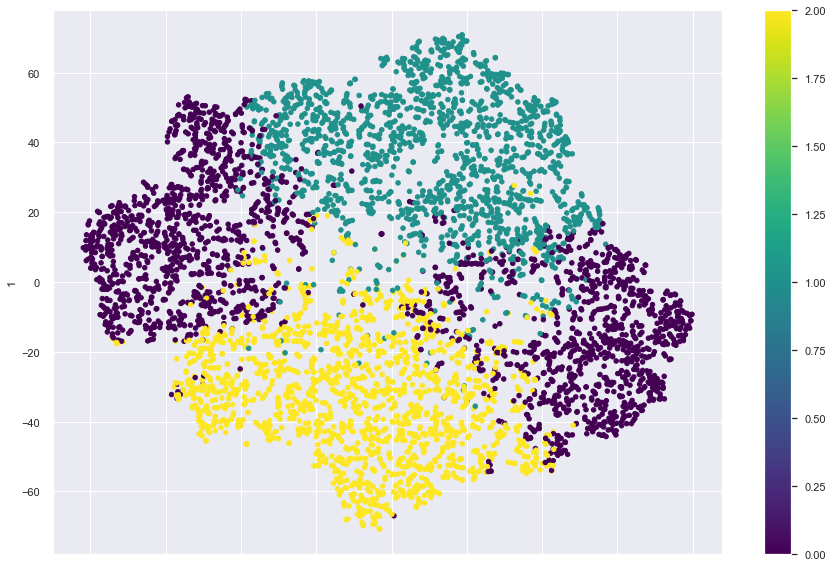

In [206]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=X_['merged_labels'], colormap='viridis', figsize=(15,10))
plt.show()

## **Assess feature importance and reclassify outliers:**

_Should i reclassify outliers??_ 

### **Using a Decision Tree:**
We get the normalized total reduction of the criterion (gini or entropy) brought by that feature (also known as Gini importance).

In [207]:
# Preparing the data
X_tree = X_.drop(columns=['prm_labels','dem_labels','merged_labels'])
y = X_["merged_labels"]

# Splitting the data:
X_train, X_test, y_train, y_test = train_test_split(
    X_tree, y, test_size=0.2, random_state=random_state
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=random_state, max_depth=5)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 96.76% of the customers correctly


In [208]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(axis=0, ascending=False)

PremMotor              0.517203
Age                    0.431481
PremHealth             0.027260
MonthSal               0.017990
PremWork               0.005116
GeoLivArea_3.0         0.000616
CustMonVal             0.000334
EducDeg_High School    0.000000
PremLife               0.000000
PremHousehold          0.000000
ClaimsRate             0.000000
Children_0.0           0.000000
EducDeg_Basic          0.000000
Children_1.0           0.000000
GeoLivArea_2.0         0.000000
GeoLivArea_4.0         0.000000
GeoLivArea_1.0         0.000000
EducDeg_PhD            0.000000
EducDeg_BScMSc         0.000000
YearsAsCustomer        0.000000
dtype: float64

run [WindowsPath('dot'), '-Kdot', '-Tsvg']


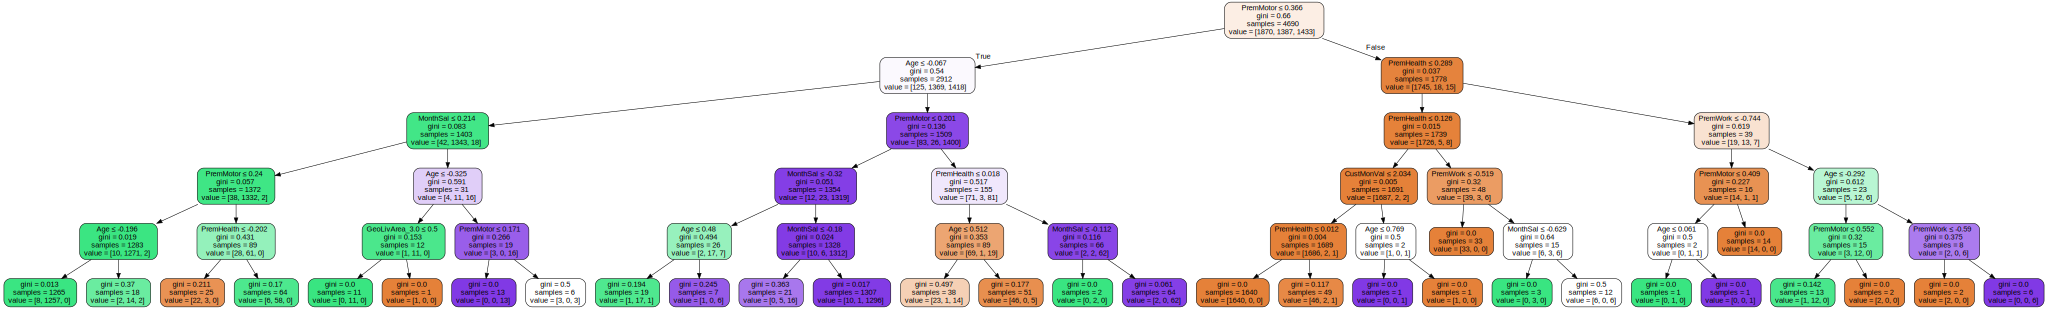

In [209]:
# Visualizing the decision tree

dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X_tree.columns.to_list(),
                           filled=True,
                           rounded=True,
                           special_characters=True)  

graphviz.Source(dot_data)

# **9. Self Organizing Map:**

A SOM is an artifcial neural network composed by a grid of output neurons
connected to an input layer.

This type of neural network uses an unsupervised learning algorithm to
fnd clusters in data without any privileged knowledge a priori.

The algorithm maps a multidimensional training set in a 2D grid of neurons
in a way that preserves the original topological relationships.

Inspired by: https://indico.lip.pt/event/396/contributions/898/attachments/995/1133/Franco_BigData.pdf

In [210]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(random_state)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    X[num_vars].values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=X.columns
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.002000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.492000, quantization error: 1.868535

 epoch: 2 ---> elapsed time:  0.542000, quantization error: 3.059023

 epoch: 3 ---> elapsed time:  0.549000, quantization error: 3.028979

 epoch: 4 ---> elapsed time:  0.516000, quantization error: 3.015654

 epoch: 5 ---> elapsed time:  0.532000, quantization error: 3.010568

 epoch: 6 ---> elapsed time:  0.536000, quantization error: 3.007932

 epoch: 7 ---> elapsed time:  0.528000, quantization error: 3.006281

 epoch: 8 ---> elapsed time:  0.516000, quantization error: 3.004687

 epoch: 9 ---> elapsed time:  0.521000, quantization error: 3.002925

 epoch: 10 ---> elapsed time:  0.629000, quantization error: 3.001519

 epoch: 11 ---> elapsed time:  0.550000, quantization error: 3.000352

 epoch: 12 ---> elapsed time:  0.587000, quantization error: 2.999222

 epoch: 13 --->

In [211]:
# Coordinates of the units in the input space
sm.get_node_vectors()

array([[ 1.08586, -0.89352,  0.89731, ...,  1.13322,  1.19435,  0.95891],
       [ 1.06622, -0.81365,  0.81604, ...,  0.75472,  1.1984 ,  0.63935],
       [ 1.00781, -0.65795,  0.65827, ...,  0.63191,  1.16254,  0.1918 ],
       ...,
       [-0.07914,  1.29363, -1.6345 , ..., -0.73172, -0.08285,  0.60223],
       [-0.02363,  1.26955, -1.62182, ..., -0.70974, -0.07135,  0.90694],
       [ 0.05733,  1.25987, -1.62841, ..., -0.72709,  0.00019,  1.13624]])

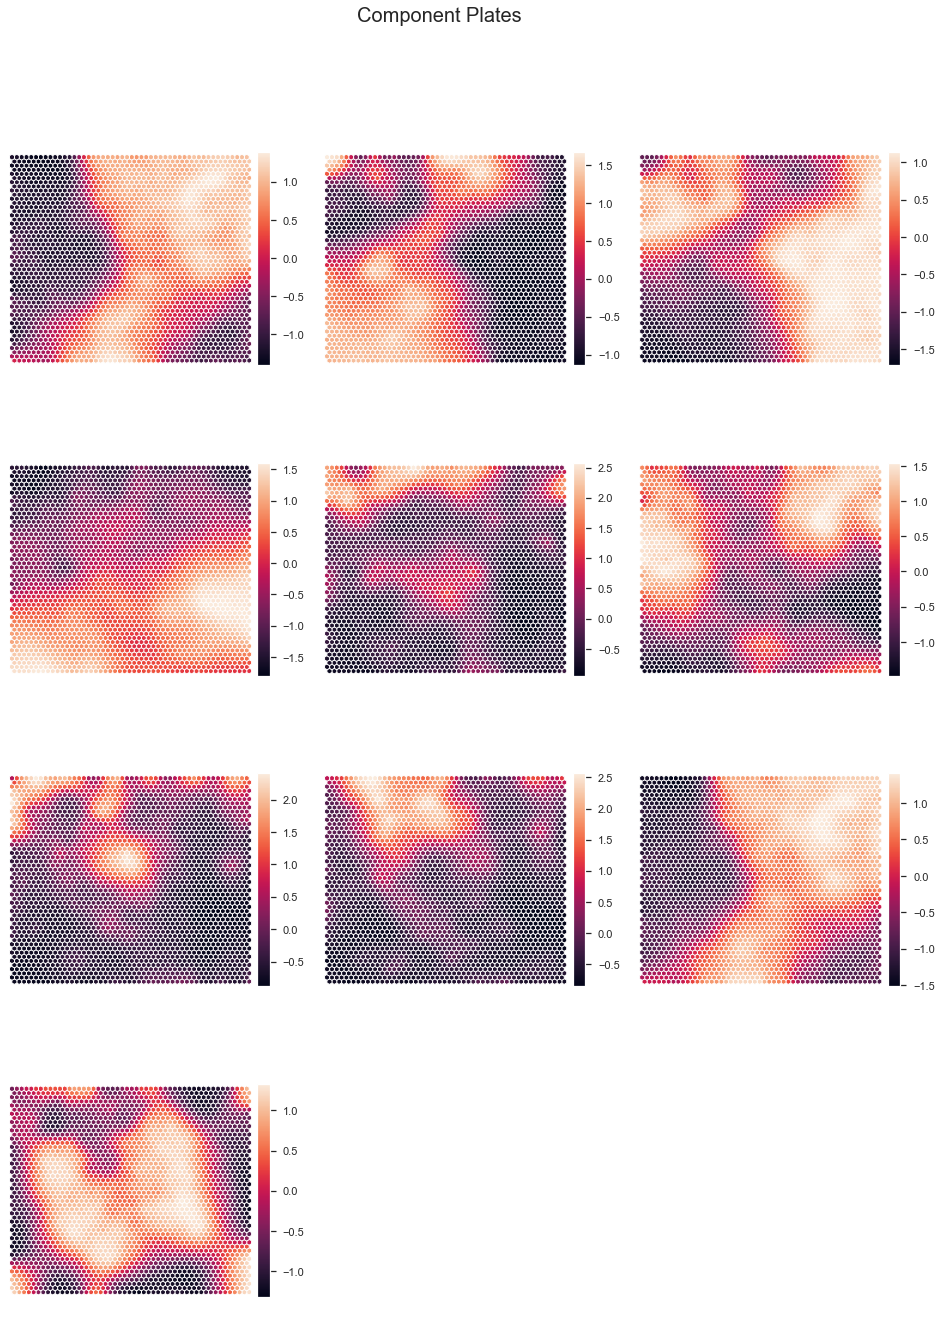

In [212]:
# Component plates on the 50x50 grid
#sns.set_theme(style="whitegrid", palette="pastel")
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Plates", fontsize=20)
plt.show()

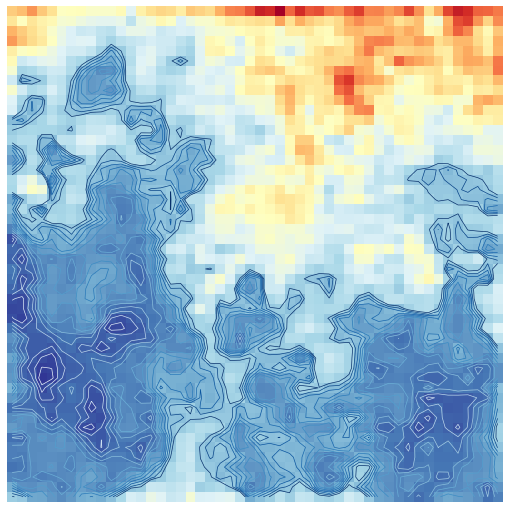

In [213]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=False, 
    contooor=True # Visualize isomorphic curves
)

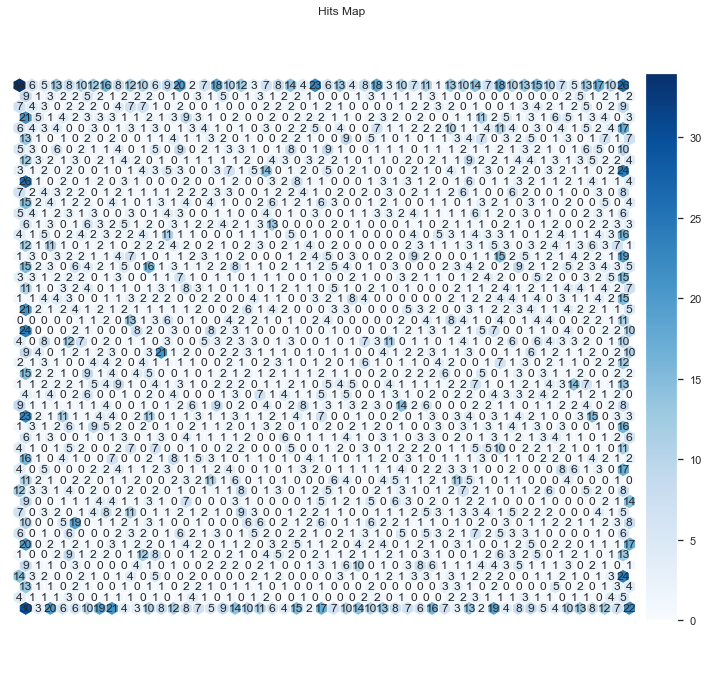

In [214]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

### __K-Means on top of SOM units:__

- We can visualize the clusters formed by labeled neurons:

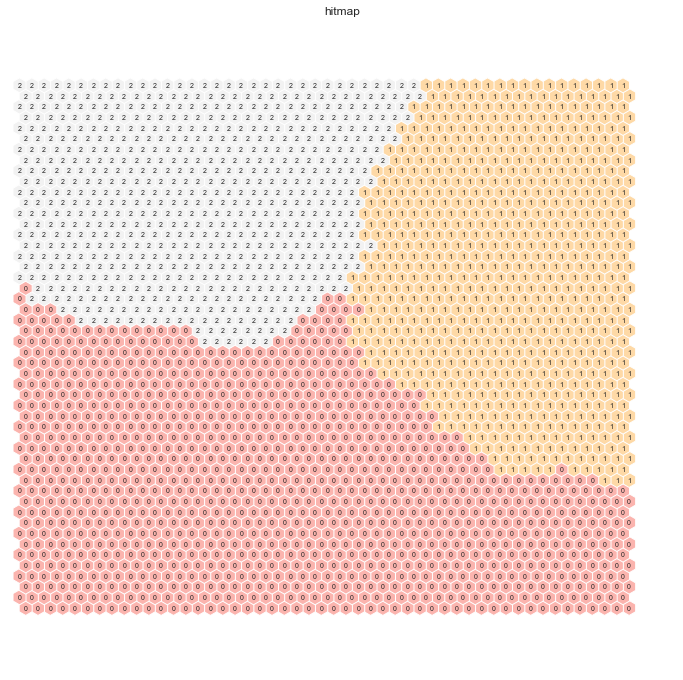

In [215]:
# Perform K-Means clustering on top of the 2500 units (sm.get_node_vectors() output)
nclus=3
kmeans = KMeans(n_clusters=nclus, init='k-means++', n_init=20, random_state=random_state)
nodeclus_labels_km = sm.cluster(kmeans)

hits  = HitMapView(12, 12, "hitmap", text_size=10) # "Clustering"
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

### __Hierarchical Clustering on top of SOM units:__

- We can visualize the clusters formed by labeled neurons:

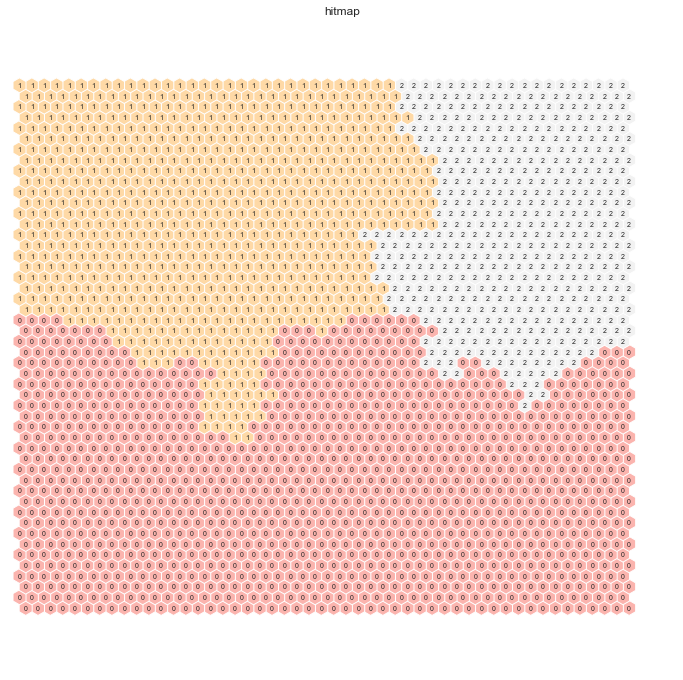

In [216]:
# Perform Hierarchical clustering on top of the 2500 units (sm.get_node_vectors() output)
nclus=3
hierclust = AgglomerativeClustering(n_clusters=nclus, linkage='ward')
nodeclus_labels_hc = sm.cluster(hierclust)

hits = HitMapView(12, 12, "hitmap", text_size=10) # "Clustering"
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

- INSERT COMMENT HERE.

### __Final SOM Clustering solution:__

In [217]:
# Check the nodes and and respective clusters
nodes = sm.get_node_vectors()

df_nodes = pd.DataFrame(nodes, columns=X[num_vars].columns)
df_nodes['label'] = nodeclus_labels_hc
df_nodes.head(2)

MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0  1.085864   -0.893524    0.897312  -1.531784       0.265548    1.316840   
1  1.066223   -0.813650    0.816039  -1.501904       0.202753    1.342564   

   PremLife  PremWork       Age  YearsAsCustomer  label  
0  1.326409  1.133219  1.194350         0.958910      0  
1  1.567208  0.754718  1.198395         0.639351      0

In [218]:
# Obtaining SOM's BMUs (Best Matching units) labels
df_bmus = pd.DataFrame(
    np.concatenate((X, np.expand_dims(sm._bmu[0],1)), axis=1),
    index=X.index, columns=np.append(X.columns,"BMU")
)
df_bmus.tail()

EducDeg_High School  EducDeg_Basic  EducDeg_BScMSc  EducDeg_PhD  \
10289                  1.0            0.0             0.0          0.0   
10291                  0.0            0.0             0.0          1.0   
10293                  0.0            0.0             1.0          0.0   
10294                  0.0            1.0             0.0          0.0   
10295                  0.0            0.0             0.0          1.0   

       MonthSal  GeoLivArea_1.0  GeoLivArea_4.0  GeoLivArea_3.0  \
10289  1.110316             0.0             1.0             0.0   
10291  0.736762             0.0             0.0             0.0   
10293  0.411408             1.0             0.0             0.0   
10294 -0.729740             0.0             0.0             0.0   
10295  0.287292             1.0             0.0             0.0   

       GeoLivArea_2.0  Children_1.0  ...  CustMonVal  ClaimsRate  PremMotor  \
10289             0.0           0.0  ...    0.214211   -0.056514  -0.871672   
10291             1.0           0.0  ...   -1.020970    0.990896   0.770014   
10293             0.0           1.0  ...    1.614226   -1.717923   0.867870   
10294             1.0           1.0  ...    0.236581   -0.128749  -1.259831   
10295             0.0           1.0  ...    1.310848   -1.501218   0.971267   

       PremHousehold  PremHealth  PremLife  PremWork       Age  \
10289       0.682619   -0.188186  2.246042  1.233153  1.509336   
10291      -0.813750    0.027802 -0.822791 -0.654388  1.123244   
10293      -0.249778   -0.501025 -0.724629 -0.993063 -0.614172   
10294       0.280362    0.439336  1.015452  2.705996 -0.678521   
10295      -0.509266   -0.517781 -0.920953 -0.719109 -0.935916   

       YearsAsCustomer     BMU  
10289         0.006737   279.0  
10291         0.310571  1159.0  
10293        -1.208600  2390.0  
10294         0.766323    41.0  
10295        -0.600932  2142.0  

[5 rows x 21 columns]

In [219]:
# Get cluster labels for each observation
X_som = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)
X_som.head(2)

EducDeg_High School  EducDeg_Basic  EducDeg_BScMSc  EducDeg_PhD  MonthSal  \
0                  1.0            0.0             0.0          0.0 -0.481507   
2                  0.0            1.0             0.0          0.0 -0.361005   

   GeoLivArea_1.0  GeoLivArea_4.0  GeoLivArea_3.0  GeoLivArea_2.0  \
0             1.0             0.0             0.0             0.0   
2             0.0             0.0             1.0             0.0   

   Children_1.0  ...  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0           1.0  ...   -1.067807   0.593003      -0.610761   -0.432156   
2           0.0  ...   -1.465100  -1.086085       0.370692   -0.797107   

   PremLife  PremWork       Age  YearsAsCustomer     BMU  label  
0  0.441765 -0.582133 -1.000264         0.158654  1844.0      1  
2  1.777990  2.230344 -0.228080        -0.752849   327.0      0  

[2 rows x 22 columns]

In [220]:
X_beforeNorm_som = X_beforeNorm.copy(deep=True)
X_beforeNorm_som[["BMU", "label"]] = X_som[["BMU", "label"]]

In [221]:
# Characterizing the final clusters
X_beforeNorm_som.drop(columns='BMU').groupby('label').mean().T

label                          0            1            2
EducDeg_High School     0.424900     0.276974     0.284946
EducDeg_Basic           0.109301     0.051724     0.050691
EducDeg_BScMSc          0.431777     0.585095     0.559908
EducDeg_PhD             0.034021     0.086207     0.104455
MonthSal             2707.824828  2471.112347  2443.736559
GeoLivArea_1.0          0.292798     0.303671     0.284946
GeoLivArea_4.0          0.417300     0.397108     0.399386
GeoLivArea_3.0          0.195078     0.205784     0.211214
GeoLivArea_2.0          0.094824     0.093437     0.104455
Children_1.0            0.596091     0.826474     0.887865
Children_0.0            0.403909     0.173526     0.112135
CustMonVal            171.501408   392.593648     7.968978
ClaimsRate              0.753319     0.388092     0.952949
PremMotor             237.318541   369.779705   408.331045
PremHousehold         239.741802   127.254616    79.745584
PremHealth            205.234339   150.078999   132.423533
PremLife               49.583891    22.837063    16.362273
PremWork               49.357492    22.538910    16.738940
Age                    51.995295    47.571746    47.067588
YearsAsCustomer        29.514658    30.324249    30.382488

## __Analysing the appropriateness of our solution:__

**Clusters R²:**

What proportion of each variables total SS is explained between clusters?

In [222]:
r2_som =  get_r2(X_som, "label")
print("Cluster solution with R^2 of %0.4f" % r2_som, "\n");

# We are essentially decomposing the R² into the R² for each variable:

get_r2_variables(X_som[num_vars + ['label']], 'label').drop('label').\
                 sort_values(axis=0, ascending=False)

Cluster solution with R^2 of 0.7404 



ClaimsRate         0.589329
PremMotor          0.557794
CustMonVal         0.503843
PremHealth         0.285176
PremLife           0.255828
PremWork           0.255153
PremHousehold      0.213412
MonthSal           0.022431
Age                0.022304
YearsAsCustomer    0.004010
dtype: float64

## __Cluster visualization using t-SNE:__

In [223]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=random_state).fit_transform(X_som[num_vars])


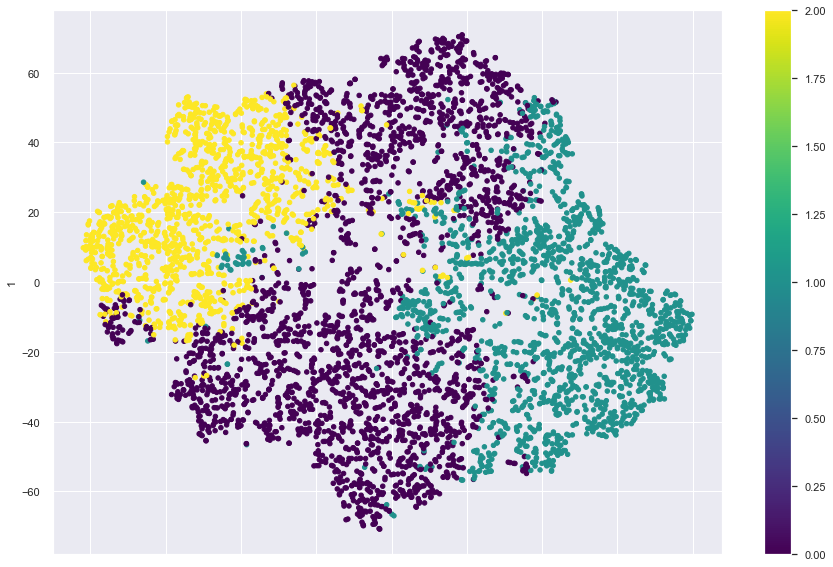

In [224]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=X_som['label'], colormap='viridis', figsize=(15,10))
plt.show()

In [225]:
t2 = time.perf_counter()#
print('time taken to run:',(t2-t1)/60.0)

time taken to run: 25.696340408333334


___